In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 1000

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


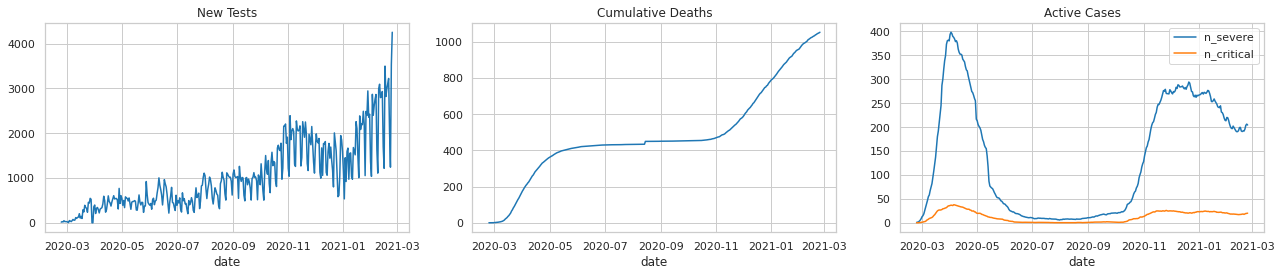

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)
df = df[df['date'] <= pd.to_datetime('2021-02-24')]

_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [3]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

In [4]:
from sklearn.metrics import r2_score

def custom_estimator(y_true, y_pred):
    return 1 - r2_score(y_true, y_pred, sample_weight=sample_weight.values)

max_weight = 5

sample_weight = df.set_index(['date'], drop=False)['date']
sample_weight = sample_weight.map(lambda d: (d - pd.to_datetime('2020-09-15').date()).days)
sample_weight = sample_weight.map(lambda d: 1 if d < 0 else max_weight)
sample_weight

date
2020-02-24    1
2020-02-25    1
2020-02-26    1
2020-02-27    1
2020-02-28    1
             ..
2021-02-20    5
2021-02-21    5
2021-02-22    5
2021-02-23    5
2021-02-24    5
Name: date, Length: 367, dtype: int64

In [5]:
import optuna as op
from util.interventions import get_interventions

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', 2500, 3400, step=1),
        n_imports=trial.suggest_float('init_n_imports', 0.9, 2.5, step=1e-1),
        beta=trial.suggest_float('init_beta', 0.02, 0.027, step=1e-3),
        rel_symp_prob=trial.suggest_float('init_rel_symp_prob', 5.8, 10.0, log=True),
        rel_severe_prob=trial.suggest_float('init_rel_severe_prob', 0.06, 0.15, log=True),
        rel_crit_prob=trial.suggest_float('init_rel_crit_prob', 0.8, 1.25, log=True),
        rel_death_prob=trial.suggest_float('init_rel_death_prob', 4.5, 10.0, log=True),
        **default_params
    )
    intervention_params = dict(
        trace_prob=trial.suggest_float('interv_trace_prob', 0.4, 0.7, step=1e-2),             # CONTACT TRACING
        trace_time=trial.suggest_float('interv_trace_time', 2.3, 3.7, step=1e-1),             #
        work_contacts=trial.suggest_float('interv_work_contacts', 0.65, 0.75, step=1e-2),     # SMART WORKING
        school_contacts=trial.suggest_float('interv_school_contacts', 0.55, 0.95, step=1e-2), # SCHOOLS CLOSED
        yellow_contacts=trial.suggest_float('interv_yellow_contacts', 0.4, 1.0, step=1e-2),   # LOCKDOWN INTERACTIONS
        orange_contacts=trial.suggest_float('interv_orange_contacts', 0.2, 0.9, step=1e-2),   #
        summer_imports=trial.suggest_float('interv_summer_imp', 5.0, 17.0, step=1e-1),        # IMPORTED CASES
        yellow_imports=trial.suggest_float('interv_yellow_imp', 0.0, 15.0, step=1e-1),        #
        orange_imports=trial.suggest_float('interv_orange_imp', 0.0, 10.0, step=1e-1),        #
        summer_beta=trial.suggest_float('interv_summer_beta', 0.02, 0.05, step=1e-3),         # VIRAL LOAD REDUCTION
        winter_beta=trial.suggest_float('interv_winter_beta', 0.05, 0.3, step=1e-3),          #
        summer_symp=trial.suggest_float('interv_summer_symp', 0.01, 0.04, log=True),          #
        winter_symp=trial.suggest_float('interv_winter_symp', 1.45, 8.0, log=True),           #
        summer_sev=trial.suggest_float('interv_summer_sev', 0.03, 0.2, log=True),             #
        winter_sev=trial.suggest_float('interv_winter_sev', 0.02, 0.5, log=True),             #
        summer_crit=trial.suggest_float('interv_summer_crit', 0.3, 1.2, log=True),            #
        winter_crit=trial.suggest_float('interv_winter_crit', 0.15, 0.65, log=True),          #
        summer_death=trial.suggest_float('interv_summer_death', 0.05, 1.2, log=True),         #
        winter_death=trial.suggest_float('interv_winter_death', 1.5, 2.5, log=True)           #
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    weights = {c: 1 for c in cols}
    mismatches = [s.compute_fit(keys=cols, weights=weights, estimator=custom_estimator).mismatch for s in msim.sims]
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-13 20:39:51,050] A new study created in memory with name: no-name-cf2c120d-af3e-4475-8236-9177402a0396
[I 2021-03-13 20:40:11,296] Trial 0 finished with value: 8.694978760061636 and parameters: {'init_pop_infected': 2914, 'init_n_imports': 2.3000000000000003, 'init_beta': 0.021, 'init_rel_symp_prob': 8.696489921042199, 'init_rel_severe_prob': 0.11280950212596635, 'init_rel_crit_prob': 0.9814105638307042, 'init_rel_death_prob': 4.577176814529664, 'interv_trace_prob': 0.4, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.66, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 15.4, 'interv_yellow_imp': 13.3, 'interv_orange_imp': 5.7, 'interv_summer_beta': 0.05, 'interv_winter_beta': 0.21800000000000003, 'interv_summer_symp': 0.03897971926452462, 'interv_winter_symp': 1.9417550003698698, 'interv_summer_sev': 0.09447474910909791, 'interv_winter_sev': 0.13691355448642428, 'interv_summe

[I 2021-03-13 20:42:49,264] Trial 8 finished with value: 8.566231273528897 and parameters: {'init_pop_infected': 2931, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.025, 'init_rel_symp_prob': 6.465615264838604, 'init_rel_severe_prob': 0.08724231959569387, 'init_rel_crit_prob': 0.9056869415256557, 'init_rel_death_prob': 9.430961096343694, 'interv_trace_prob': 0.44, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.53, 'interv_summer_imp': 15.4, 'interv_yellow_imp': 8.200000000000001, 'interv_orange_imp': 5.6000000000000005, 'interv_summer_beta': 0.044, 'interv_winter_beta': 0.132, 'interv_summer_symp': 0.01270435787161886, 'interv_winter_symp': 6.176457985812636, 'interv_summer_sev': 0.06819670215624632, 'interv_winter_sev': 0.1190306656247975, 'interv_summer_crit': 0.4668040143828861, 'interv_winter_crit': 0.1697329319655799, 'interv_summer_death': 0.16078624544828185,

[I 2021-03-13 20:45:18,204] Trial 16 finished with value: 13.955602607904526 and parameters: {'init_pop_infected': 2598, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 7.049549497394755, 'init_rel_severe_prob': 0.07630590070923772, 'init_rel_crit_prob': 1.2337826698593883, 'init_rel_death_prob': 4.905517936933423, 'interv_trace_prob': 0.49, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.6000000000000001, 'interv_orange_contacts': 0.2, 'interv_summer_imp': 13.8, 'interv_yellow_imp': 9.5, 'interv_orange_imp': 4.0, 'interv_summer_beta': 0.024, 'interv_winter_beta': 0.22999999999999998, 'interv_summer_symp': 0.024512044794017945, 'interv_winter_symp': 1.711288319441049, 'interv_summer_sev': 0.1854857833123746, 'interv_winter_sev': 0.07197985630890742, 'interv_summer_crit': 0.5998739221019139, 'interv_winter_crit': 0.2825999463164278, 'interv_summer_death': 0.29

[I 2021-03-13 20:47:48,169] Trial 24 finished with value: 6.060562608039555 and parameters: {'init_pop_infected': 2663, 'init_n_imports': 2.1, 'init_beta': 0.023, 'init_rel_symp_prob': 6.593192699185438, 'init_rel_severe_prob': 0.14895167600413364, 'init_rel_crit_prob': 1.0963819327074655, 'init_rel_death_prob': 6.059541413128284, 'interv_trace_prob': 0.4, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.65, 'interv_orange_contacts': 0.5900000000000001, 'interv_summer_imp': 5.2, 'interv_yellow_imp': 3.3000000000000003, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.039, 'interv_winter_beta': 0.271, 'interv_summer_symp': 0.029052033452015735, 'interv_winter_symp': 3.8395479662335337, 'interv_summer_sev': 0.05709728572283866, 'interv_winter_sev': 0.18047134034613882, 'interv_summer_crit': 0.43172593806919907, 'interv_winter_crit': 0.3232488862497115, 'interv_summer_death': 0.43126133789971943, 'interv_winter_death': 2.

[I 2021-03-13 20:50:25,985] Trial 32 finished with value: 6.542705507899684 and parameters: {'init_pop_infected': 2912, 'init_n_imports': 2.3000000000000003, 'init_beta': 0.022, 'init_rel_symp_prob': 7.991235453506121, 'init_rel_severe_prob': 0.1132721654706486, 'init_rel_crit_prob': 1.1196754092585433, 'init_rel_death_prob': 4.512414860995852, 'interv_trace_prob': 0.4, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.6100000000000001, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.66, 'interv_summer_imp': 7.0, 'interv_yellow_imp': 0.8, 'interv_orange_imp': 3.3000000000000003, 'interv_summer_beta': 0.039, 'interv_winter_beta': 0.28700000000000003, 'interv_summer_symp': 0.03506361826050073, 'interv_winter_symp': 2.60632629525552, 'interv_summer_sev': 0.06997472163683943, 'interv_winter_sev': 0.17666291303148693, 'interv_summer_crit': 0.5938357618513738, 'interv_winter_crit': 0.37777939591935983, 'interv_summer_death': 0.382788389675917, 'i

[I 2021-03-13 20:53:06,643] Trial 40 finished with value: 6.824628924756247 and parameters: {'init_pop_infected': 2560, 'init_n_imports': 2.4, 'init_beta': 0.021, 'init_rel_symp_prob': 9.996551246662014, 'init_rel_severe_prob': 0.13845831529771774, 'init_rel_crit_prob': 1.1881509835595505, 'init_rel_death_prob': 4.588919203432547, 'interv_trace_prob': 0.54, 'interv_trace_time': 3.7, 'interv_work_contacts': 0.66, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.68, 'interv_orange_contacts': 0.8400000000000001, 'interv_summer_imp': 9.5, 'interv_yellow_imp': 7.9, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.165, 'interv_summer_symp': 0.022411211969411787, 'interv_winter_symp': 5.147991303915718, 'interv_summer_sev': 0.03631496843604131, 'interv_winter_sev': 0.4877294198965928, 'interv_summer_crit': 0.782938044552616, 'interv_winter_crit': 0.19902807162848768, 'interv_summer_death': 1.0288212996501398, 'interv_winter_death': 1.9089

[I 2021-03-13 20:55:39,037] Trial 48 finished with value: 5.493934927150131 and parameters: {'init_pop_infected': 2631, 'init_n_imports': 2.4, 'init_beta': 0.021, 'init_rel_symp_prob': 9.79089354050772, 'init_rel_severe_prob': 0.1219294195307414, 'init_rel_crit_prob': 1.1430805876817902, 'init_rel_death_prob': 4.510119857705505, 'interv_trace_prob': 0.5900000000000001, 'interv_trace_time': 2.9, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.52, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 11.0, 'interv_yellow_imp': 8.4, 'interv_orange_imp': 0.6000000000000001, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.22500000000000003, 'interv_summer_symp': 0.018940339957953484, 'interv_winter_symp': 5.907153078286534, 'interv_summer_sev': 0.030445276017760408, 'interv_winter_sev': 0.3222869700324599, 'interv_summer_crit': 1.0966497603913234, 'interv_winter_crit': 0.22937451606469916, 'interv_summer_death': 0.5358

[I 2021-03-13 20:58:22,610] Trial 56 finished with value: 14.197348587659258 and parameters: {'init_pop_infected': 2695, 'init_n_imports': 2.5, 'init_beta': 0.021, 'init_rel_symp_prob': 8.54723632581849, 'init_rel_severe_prob': 0.12531464246242255, 'init_rel_crit_prob': 1.141366995181266, 'init_rel_death_prob': 5.769428507633022, 'interv_trace_prob': 0.5900000000000001, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.75, 'interv_yellow_contacts': 0.41000000000000003, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 9.8, 'interv_yellow_imp': 8.200000000000001, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.245, 'interv_summer_symp': 0.01679447713543426, 'interv_winter_symp': 6.319715680112649, 'interv_summer_sev': 0.03538374027599869, 'interv_winter_sev': 0.4870796629369617, 'interv_summer_crit': 1.0792105235324632, 'interv_winter_crit': 0.2637870946912377, 'interv_summer_death': 0.55794

[I 2021-03-13 21:00:57,747] Trial 64 finished with value: 5.808521390863557 and parameters: {'init_pop_infected': 2838, 'init_n_imports': 2.4, 'init_beta': 0.022, 'init_rel_symp_prob': 9.189224828268657, 'init_rel_severe_prob': 0.140536803935287, 'init_rel_crit_prob': 1.1299035175300411, 'init_rel_death_prob': 4.6995833751611835, 'interv_trace_prob': 0.5700000000000001, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 7.0, 'interv_orange_imp': 3.6, 'interv_summer_beta': 0.03, 'interv_winter_beta': 0.21200000000000002, 'interv_summer_symp': 0.03132135220280126, 'interv_winter_symp': 6.167194303813808, 'interv_summer_sev': 0.03027036859502556, 'interv_winter_sev': 0.2562303468410068, 'interv_summer_crit': 0.9940880636727157, 'interv_winter_crit': 0.18501487735305835, 'interv_summer_death': 0.5788846886684423, 'i

[I 2021-03-13 21:03:30,093] Trial 72 finished with value: 5.536780067309949 and parameters: {'init_pop_infected': 2825, 'init_n_imports': 1.6, 'init_beta': 0.022, 'init_rel_symp_prob': 9.991802041953482, 'init_rel_severe_prob': 0.13547847551182032, 'init_rel_crit_prob': 1.1772590351870438, 'init_rel_death_prob': 5.146040189837793, 'interv_trace_prob': 0.5800000000000001, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 14.200000000000001, 'interv_yellow_imp': 8.4, 'interv_orange_imp': 1.0, 'interv_summer_beta': 0.03, 'interv_winter_beta': 0.185, 'interv_summer_symp': 0.03155515605781015, 'interv_winter_symp': 5.638374078293288, 'interv_summer_sev': 0.04874281463016369, 'interv_winter_sev': 0.4295339295427482, 'interv_summer_crit': 0.7722874302228051, 'interv_winter_crit': 0.24977559897525994, 'interv_summer_death': 0.8455105741206297, '

[I 2021-03-13 21:06:03,112] Trial 80 finished with value: 10.885098747271607 and parameters: {'init_pop_infected': 2677, 'init_n_imports': 1.4, 'init_beta': 0.024, 'init_rel_symp_prob': 8.315452161924558, 'init_rel_severe_prob': 0.12998522971278806, 'init_rel_crit_prob': 1.1101451063684973, 'init_rel_death_prob': 5.597605496396431, 'interv_trace_prob': 0.51, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.73, 'interv_orange_contacts': 0.24000000000000002, 'interv_summer_imp': 14.9, 'interv_yellow_imp': 3.6, 'interv_orange_imp': 1.0, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.196, 'interv_summer_symp': 0.016334672577477383, 'interv_winter_symp': 6.009747476275631, 'interv_summer_sev': 0.04209840989674132, 'interv_winter_sev': 0.4984275697342003, 'interv_summer_crit': 1.1539446697986295, 'interv_winter_crit': 0.24123676259028284, 'interv_summer_death': 0.5001939663837804, 'interv_winter_death': 2.

[I 2021-03-13 21:08:35,917] Trial 88 finished with value: 4.957429973481871 and parameters: {'init_pop_infected': 3000, 'init_n_imports': 1.0, 'init_beta': 0.021, 'init_rel_symp_prob': 9.388961812793625, 'init_rel_severe_prob': 0.1413151771814818, 'init_rel_crit_prob': 1.1936139412891205, 'init_rel_death_prob': 4.863642193293728, 'interv_trace_prob': 0.63, 'interv_trace_time': 3.5999999999999996, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.77, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 8.6, 'interv_yellow_imp': 7.2, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.203, 'interv_summer_symp': 0.03749818178456883, 'interv_winter_symp': 4.2113911045544095, 'interv_summer_sev': 0.10753678599821144, 'interv_winter_sev': 0.49493651520852455, 'interv_summer_crit': 0.8492449016507101, 'interv_winter_crit': 0.31084270874286957, 'interv_summer_death': 1.0765768129325783, 'interv_winte

[I 2021-03-13 21:11:05,297] Trial 96 finished with value: 4.91865562815457 and parameters: {'init_pop_infected': 2982, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 9.608987072438055, 'init_rel_severe_prob': 0.1494206420678153, 'init_rel_crit_prob': 1.202198519450866, 'init_rel_death_prob': 4.742169298878431, 'interv_trace_prob': 0.64, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.74, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.74, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 6.2, 'interv_orange_imp': 3.8000000000000003, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.23199999999999998, 'interv_summer_symp': 0.038296192474057376, 'interv_winter_symp': 3.581110400259757, 'interv_summer_sev': 0.14813495862967274, 'interv_winter_sev': 0.4963779819947663, 'interv_summer_crit': 0.7232456021172323, 'interv_winter_crit': 0.3396650026547236, 'interv_summer_death': 0.7605777905067002, 'i

[I 2021-03-13 21:13:33,915] Trial 104 finished with value: 5.287850065061195 and parameters: {'init_pop_infected': 2912, 'init_n_imports': 0.9, 'init_beta': 0.021, 'init_rel_symp_prob': 9.565950415725275, 'init_rel_severe_prob': 0.1315210341565461, 'init_rel_crit_prob': 1.2469885761638484, 'init_rel_death_prob': 4.727875578308462, 'interv_trace_prob': 0.53, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.76, 'interv_yellow_contacts': 0.69, 'interv_orange_contacts': 0.8, 'interv_summer_imp': 9.600000000000001, 'interv_yellow_imp': 5.1000000000000005, 'interv_orange_imp': 3.4000000000000004, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.22899999999999998, 'interv_summer_symp': 0.011976907250737016, 'interv_winter_symp': 4.218910863210331, 'interv_summer_sev': 0.13510327341479839, 'interv_winter_sev': 0.49690669931546566, 'interv_summer_crit': 0.9290709395091078, 'interv_winter_crit': 0.2830177139177074, 'interv_summer_death': 0.8728336828670717,

[I 2021-03-13 21:16:03,857] Trial 112 finished with value: 9.469019350946603 and parameters: {'init_pop_infected': 2902, 'init_n_imports': 0.9, 'init_beta': 0.024, 'init_rel_symp_prob': 9.18559558060974, 'init_rel_severe_prob': 0.13074247822192905, 'init_rel_crit_prob': 1.17138080356831, 'init_rel_death_prob': 4.616905240357785, 'interv_trace_prob': 0.54, 'interv_trace_time': 3.5999999999999996, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.77, 'interv_yellow_contacts': 0.68, 'interv_orange_contacts': 0.77, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 7.0, 'interv_orange_imp': 3.8000000000000003, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21600000000000003, 'interv_summer_symp': 0.01048493503100465, 'interv_winter_symp': 5.030066305360434, 'interv_summer_sev': 0.14451499765787473, 'interv_winter_sev': 0.4282420940627163, 'interv_summer_crit': 0.8736278470205819, 'interv_winter_crit': 0.2041008508311358, 'interv_summer_death': 0.9511744191773218, 'interv_winter_d

[I 2021-03-13 21:18:34,323] Trial 120 finished with value: 3.998166203436669 and parameters: {'init_pop_infected': 2948, 'init_n_imports': 0.9, 'init_beta': 0.022, 'init_rel_symp_prob': 8.505240604802898, 'init_rel_severe_prob': 0.12827736415735072, 'init_rel_crit_prob': 1.1191071168976892, 'init_rel_death_prob': 5.156564907794272, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 3.4000000000000004, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.22100000000000003, 'interv_summer_symp': 0.025192277498441128, 'interv_winter_symp': 4.5699397677046045, 'interv_summer_sev': 0.06999546365601958, 'interv_winter_sev': 0.4138057475851294, 'interv_summer_crit': 0.7958447025959327, 'interv_winter_crit': 0.295113965109765, 'interv_summe

[I 2021-03-13 21:21:06,037] Trial 128 finished with value: 5.042104361734239 and parameters: {'init_pop_infected': 2973, 'init_n_imports': 1.1, 'init_beta': 0.022, 'init_rel_symp_prob': 8.41172411556213, 'init_rel_severe_prob': 0.12755679582791657, 'init_rel_crit_prob': 1.179211289457038, 'init_rel_death_prob': 5.547123879957827, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 1.2000000000000002, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.257, 'interv_summer_symp': 0.02435989153511691, 'interv_winter_symp': 5.2849160272549645, 'interv_summer_sev': 0.06295996703116466, 'interv_winter_sev': 0.36736755751223604, 'interv_summer_crit': 0.7962777297944595, 'interv_winter_crit': 0.32465218741186175, 'interv_summer_death': 0.51

[I 2021-03-13 21:23:37,337] Trial 136 finished with value: 5.392618811919956 and parameters: {'init_pop_infected': 2881, 'init_n_imports': 0.9, 'init_beta': 0.022, 'init_rel_symp_prob': 8.635318300467283, 'init_rel_severe_prob': 0.13283805781451996, 'init_rel_crit_prob': 1.2091954498563535, 'init_rel_death_prob': 5.6963682872904355, 'interv_trace_prob': 0.65, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.6799999999999999, 'interv_summer_imp': 10.4, 'interv_yellow_imp': 3.2, 'interv_orange_imp': 0.8, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.23299999999999998, 'interv_summer_symp': 0.02703469958075915, 'interv_winter_symp': 5.65854371299867, 'interv_summer_sev': 0.06435971789034033, 'interv_winter_sev': 0.31385956858963365, 'interv_summer_crit': 0.6618540684694292, 'interv_winter_crit': 0.3424567314150881, 'interv_summe

[I 2021-03-13 21:26:08,430] Trial 144 finished with value: 5.589576714149136 and parameters: {'init_pop_infected': 2943, 'init_n_imports': 0.9, 'init_beta': 0.022, 'init_rel_symp_prob': 8.71719577529484, 'init_rel_severe_prob': 0.13099580861284488, 'init_rel_crit_prob': 1.1895717706590943, 'init_rel_death_prob': 6.127240365895976, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.7100000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 12.5, 'interv_yellow_imp': 3.1, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.037000000000000005, 'interv_winter_beta': 0.238, 'interv_summer_symp': 0.020863213346417542, 'interv_winter_symp': 3.1940002557362868, 'interv_summer_sev': 0.07987220424437999, 'interv_winter_sev': 0.34736289746842164, 'interv_summer_crit': 0.5753325206271859, 'interv_winter_crit': 0.37536396421022006, 'interv_summer_death': 0.8182988448272

[I 2021-03-13 21:28:39,430] Trial 152 finished with value: 5.878187546642913 and parameters: {'init_pop_infected': 2959, 'init_n_imports': 1.1, 'init_beta': 0.022, 'init_rel_symp_prob': 8.752436568647173, 'init_rel_severe_prob': 0.13223913901886258, 'init_rel_crit_prob': 1.2068361891882018, 'init_rel_death_prob': 6.18777877916192, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.73, 'interv_yellow_contacts': 0.99, 'interv_orange_contacts': 0.8400000000000001, 'interv_summer_imp': 9.7, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.038000000000000006, 'interv_winter_beta': 0.241, 'interv_summer_symp': 0.02582113314300295, 'interv_winter_symp': 5.481229589553358, 'interv_summer_sev': 0.06015938565806262, 'interv_winter_sev': 0.4068343527878796, 'interv_summer_crit': 0.7544267114082028, 'interv_winter_crit': 0.32989057204353356, 'interv_summer_death': 0.93

[I 2021-03-13 21:31:11,491] Trial 160 finished with value: 4.347370085077327 and parameters: {'init_pop_infected': 3018, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.507544947573366, 'init_rel_severe_prob': 0.13993797352076276, 'init_rel_crit_prob': 1.1293343650710534, 'init_rel_death_prob': 5.619891697686558, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.8400000000000001, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 3.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.21000000000000002, 'interv_summer_symp': 0.028837307037478013, 'interv_winter_symp': 6.699743881751762, 'interv_summer_sev': 0.07160573282964651, 'interv_winter_sev': 0.42595907170014413, 'interv_summer_crit': 0.49948622036959056, 'interv_winter_crit': 0.2883782904499547, 'interv_summer_death': 0.4667628686020356

[I 2021-03-13 21:33:42,703] Trial 168 finished with value: 4.706402087569394 and parameters: {'init_pop_infected': 3045, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.245043787302462, 'init_rel_severe_prob': 0.14196328670103678, 'init_rel_crit_prob': 1.1771957808386597, 'init_rel_death_prob': 5.284213697296769, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.8200000000000001, 'interv_summer_imp': 9.4, 'interv_yellow_imp': 4.5, 'interv_orange_imp': 0.8, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.21700000000000003, 'interv_summer_symp': 0.030435324640896377, 'interv_winter_symp': 6.921280277558154, 'interv_summer_sev': 0.06989012450240412, 'interv_winter_sev': 0.43418515469852154, 'interv_summer_crit': 0.6084174876290839, 'interv_winter_crit': 0.28362898888755217, 'interv_summer_death': 0.4048236313328812

[I 2021-03-13 21:36:13,634] Trial 176 finished with value: 5.544700719624096 and parameters: {'init_pop_infected': 3047, 'init_n_imports': 1.0, 'init_beta': 0.024, 'init_rel_symp_prob': 7.146336187091399, 'init_rel_severe_prob': 0.141345069324213, 'init_rel_crit_prob': 1.1230121721181514, 'init_rel_death_prob': 5.737821090603315, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 3.5, 'interv_orange_imp': 1.0, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.21400000000000002, 'interv_summer_symp': 0.02859924302188931, 'interv_winter_symp': 7.139163103878214, 'interv_summer_sev': 0.06291967252881672, 'interv_winter_sev': 0.3895560722444816, 'interv_summer_crit': 0.6459835743948115, 'interv_winter_crit': 0.2584028104689972, 'interv_summer_death': 0.32581840532105455, 'interv_winter_death': 2.498839

[I 2021-03-13 21:38:45,195] Trial 184 finished with value: 4.4771420554080255 and parameters: {'init_pop_infected': 3051, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.2545495752269575, 'init_rel_severe_prob': 0.13323702757417763, 'init_rel_crit_prob': 1.1774079450402828, 'init_rel_death_prob': 5.527494386622749, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 9.0, 'interv_yellow_imp': 3.7, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.20600000000000002, 'interv_summer_symp': 0.02673456886686984, 'interv_winter_symp': 5.966732247089568, 'interv_summer_sev': 0.060675421679212235, 'interv_winter_sev': 0.4518051728300543, 'interv_summer_crit': 0.4704026627174711, 'interv_winter_crit': 0.28404286684847235, 'interv_summer_death': 0.479442331534005

[I 2021-03-13 21:41:17,078] Trial 192 finished with value: 4.759665357509033 and parameters: {'init_pop_infected': 3039, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.203562143822367, 'init_rel_severe_prob': 0.13267994974963954, 'init_rel_crit_prob': 1.1164854882848474, 'init_rel_death_prob': 5.485261011187278, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 10.2, 'interv_yellow_imp': 4.0, 'interv_orange_imp': 1.0, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.194, 'interv_summer_symp': 0.027173588727219696, 'interv_winter_symp': 6.699676628905741, 'interv_summer_sev': 0.0658302352968117, 'interv_winter_sev': 0.44669096462222635, 'interv_summer_crit': 0.48749520627896914, 'interv_winter_crit': 0.29910786762112024, 'interv_summer_death': 0.41125342963770195, 'interv_winter_death': 2

[I 2021-03-13 21:43:49,340] Trial 200 finished with value: 4.8892800334323345 and parameters: {'init_pop_infected': 3020, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 6.840658653544443, 'init_rel_severe_prob': 0.12522104166702042, 'init_rel_crit_prob': 0.912044058263273, 'init_rel_death_prob': 5.4659544913994, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 10.600000000000001, 'interv_yellow_imp': 3.3000000000000003, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.038000000000000006, 'interv_winter_beta': 0.19, 'interv_summer_symp': 0.026684039629371836, 'interv_winter_symp': 5.2078162119882965, 'interv_summer_sev': 0.036478478719449405, 'interv_winter_sev': 0.4987589489802297, 'interv_summer_crit': 0.5764627288685686, 'interv_winter_crit': 0.3197294205799567, 'interv_summer_death': 0.3838356366120868

[I 2021-03-13 21:46:20,825] Trial 208 finished with value: 6.806652023842883 and parameters: {'init_pop_infected': 2955, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.262292143311528, 'init_rel_severe_prob': 0.13616036250070832, 'init_rel_crit_prob': 1.1813880920873232, 'init_rel_death_prob': 5.495988969003297, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 9.600000000000001, 'interv_yellow_imp': 5.1000000000000005, 'interv_orange_imp': 1.3, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.127, 'interv_summer_symp': 0.027144313375269048, 'interv_winter_symp': 6.419679761332219, 'interv_summer_sev': 0.0357201890335055, 'interv_winter_sev': 0.49901630321779533, 'interv_summer_crit': 0.5941795486816979, 'interv_winter_crit': 0.28776414394706895, 'interv_summer_death': 0.210619123648416, 

[I 2021-03-13 21:48:52,573] Trial 216 finished with value: 4.568186729856591 and parameters: {'init_pop_infected': 3017, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.305961993175026, 'init_rel_severe_prob': 0.1355745541165274, 'init_rel_crit_prob': 1.1716598865162302, 'init_rel_death_prob': 5.716082743318971, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.78, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 4.1000000000000005, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.037000000000000005, 'interv_winter_beta': 0.22999999999999998, 'interv_summer_symp': 0.030990996867395683, 'interv_winter_symp': 4.456169398528782, 'interv_summer_sev': 0.06706540286607159, 'interv_winter_sev': 0.4759315532416437, 'interv_summer_crit': 0.6239875822169423, 'interv_winter_crit': 0.2843816116890017, 'interv_summ

[I 2021-03-13 21:51:23,722] Trial 224 finished with value: 5.464265529093368 and parameters: {'init_pop_infected': 2975, 'init_n_imports': 1.1, 'init_beta': 0.023, 'init_rel_symp_prob': 7.317103257380066, 'init_rel_severe_prob': 0.13400848831596812, 'init_rel_crit_prob': 1.1102904774904865, 'init_rel_death_prob': 6.838723257848159, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.79, 'interv_summer_imp': 10.3, 'interv_yellow_imp': 4.0, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.037000000000000005, 'interv_winter_beta': 0.22200000000000003, 'interv_summer_symp': 0.02831578073109631, 'interv_winter_symp': 4.400009945237101, 'interv_summer_sev': 0.050970551972775474, 'interv_winter_sev': 0.4542755564533762, 'interv_summer_crit': 0.830485675530888, 'interv_winter_crit': 0.35375927331056134, 'interv_summer_death': 0.2729163212481097

[I 2021-03-13 21:53:53,858] Trial 232 finished with value: 5.500989475388309 and parameters: {'init_pop_infected': 3031, 'init_n_imports': 0.9, 'init_beta': 0.022, 'init_rel_symp_prob': 8.565685360731619, 'init_rel_severe_prob': 0.1370397821788631, 'init_rel_crit_prob': 1.1424883139321627, 'init_rel_death_prob': 5.703828547778881, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 8.8, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.038000000000000006, 'interv_winter_beta': 0.22300000000000003, 'interv_summer_symp': 0.026213873139330428, 'interv_winter_symp': 4.74256606439465, 'interv_summer_sev': 0.04429007863077998, 'interv_winter_sev': 0.41309751094908037, 'interv_summer_crit': 0.8479065884728682, 'interv_winter_crit': 0.30627723387531325, 'interv_summer_death': 0.2

[I 2021-03-13 21:56:26,114] Trial 240 finished with value: 9.072019204804187 and parameters: {'init_pop_infected': 3072, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.1266597906832665, 'init_rel_severe_prob': 0.13215468902445482, 'init_rel_crit_prob': 1.1180621955578511, 'init_rel_death_prob': 5.648108104227217, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.81, 'interv_summer_imp': 10.8, 'interv_yellow_imp': 3.5, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.235, 'interv_summer_symp': 0.03059451992727743, 'interv_winter_symp': 4.618738423178281, 'interv_summer_sev': 0.06287916731144594, 'interv_winter_sev': 0.44639889052168524, 'interv_summer_crit': 0.6234590490964383, 'interv_winter_crit': 0.32852090353917396, 'interv_summer_death': 0.2912870996976517, 'interv_winter_death': 2.3463254098375

[I 2021-03-13 21:58:57,382] Trial 248 finished with value: 5.024729768600427 and parameters: {'init_pop_infected': 2974, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 8.667222646152256, 'init_rel_severe_prob': 0.12605931484258673, 'init_rel_crit_prob': 1.1921102940544723, 'init_rel_death_prob': 7.525434446659276, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.8700000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 9.8, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 1.4000000000000001, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21800000000000003, 'interv_summer_symp': 0.03397803552772676, 'interv_winter_symp': 3.8909963676861232, 'interv_summer_sev': 0.12547472018760866, 'interv_winter_sev': 0.42929534627823496, 'interv_summer_crit': 0.7590886870970569, 'interv_winter_crit': 0.30587853079414234, 'interv_summer_death': 0.46

[I 2021-03-13 22:01:30,628] Trial 256 finished with value: 5.166886370790041 and parameters: {'init_pop_infected': 3002, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 8.533402182758968, 'init_rel_severe_prob': 0.12752108367433326, 'init_rel_crit_prob': 1.1859130869734145, 'init_rel_death_prob': 7.251214651557544, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 3.2, 'interv_orange_imp': 6.7, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.21000000000000002, 'interv_summer_symp': 0.03538544225558065, 'interv_winter_symp': 3.770862267196006, 'interv_summer_sev': 0.12029247212731474, 'interv_winter_sev': 0.37042799640599905, 'interv_summer_crit': 0.7271922636918742, 'interv_winter_crit': 0.2943369823615292, 'interv_summer_death': 0.38825438771500304, 'interv_winte

[I 2021-03-13 22:04:03,028] Trial 264 finished with value: 12.69925665993201 and parameters: {'init_pop_infected': 2956, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.902654702686497, 'init_rel_severe_prob': 0.12572745638732546, 'init_rel_crit_prob': 1.1934016684674256, 'init_rel_death_prob': 7.268696812078489, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.73, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.91, 'interv_orange_contacts': 0.8400000000000001, 'interv_summer_imp': 5.2, 'interv_yellow_imp': 2.9000000000000004, 'interv_orange_imp': 6.300000000000001, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.22100000000000003, 'interv_summer_symp': 0.03504554194210476, 'interv_winter_symp': 4.226326997313181, 'interv_summer_sev': 0.055561951968734064, 'interv_winter_sev': 0.3893153723514347, 'interv_summer_crit': 0.7629553653577823, 'interv_winter_crit': 0.28883741028911375, 'interv_summer_death': 0.42

[I 2021-03-13 22:06:35,292] Trial 272 finished with value: 4.701879060171557 and parameters: {'init_pop_infected': 2927, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.0827641025922015, 'init_rel_severe_prob': 0.11432326573849422, 'init_rel_crit_prob': 1.2133228124826663, 'init_rel_death_prob': 7.749786943630655, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.75, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.91, 'interv_orange_contacts': 0.8200000000000001, 'interv_summer_imp': 9.9, 'interv_yellow_imp': 3.2, 'interv_orange_imp': 8.3, 'interv_summer_beta': 0.038000000000000006, 'interv_winter_beta': 0.20400000000000001, 'interv_summer_symp': 0.034179305102509515, 'interv_winter_symp': 3.919088528033699, 'interv_summer_sev': 0.10810949680308267, 'interv_winter_sev': 0.43707932961235707, 'interv_summer_crit': 0.517733435585444, 'interv_winter_crit': 0.3033431566000907, 'interv_summer_death': 0.5168106493946909, 'interv_winte

[I 2021-03-13 22:09:06,039] Trial 280 finished with value: 13.364188407179329 and parameters: {'init_pop_infected': 2982, 'init_n_imports': 1.1, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 7.0165410137197295, 'init_rel_severe_prob': 0.11069271002293667, 'init_rel_crit_prob': 1.1631052699638138, 'init_rel_death_prob': 7.988025592683505, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 9.9, 'interv_yellow_imp': 3.1, 'interv_orange_imp': 8.6, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.21000000000000002, 'interv_summer_symp': 0.032008897601305736, 'interv_winter_symp': 4.40518715403578, 'interv_summer_sev': 0.10620561924925237, 'interv_winter_sev': 0.4248258389610131, 'interv_summer_crit': 0.5413772879851848, 'interv_winter_crit': 0.32902454271898424, 'interv_summer_death': 0.36791421109957

[I 2021-03-13 22:11:29,250] Trial 288 finished with value: 5.504357234187897 and parameters: {'init_pop_infected': 2949, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 6.880677576756708, 'init_rel_severe_prob': 0.11538305267306369, 'init_rel_crit_prob': 1.1865964593829115, 'init_rel_death_prob': 7.488582218068282, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 10.600000000000001, 'interv_yellow_imp': 2.5, 'interv_orange_imp': 8.5, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.245, 'interv_summer_symp': 0.034041559826295434, 'interv_winter_symp': 7.1444073121460665, 'interv_summer_sev': 0.10225611501213057, 'interv_winter_sev': 0.45973944281083545, 'interv_summer_crit': 0.7402151151789831, 'interv_winter_crit': 0.26953531854308016, 'interv_summer_death': 0.5128768031387222, 'interv_wi

[I 2021-03-13 22:13:45,032] Trial 296 finished with value: 12.634034810908256 and parameters: {'init_pop_infected': 3001, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.135576692943955, 'init_rel_severe_prob': 0.11113848410781065, 'init_rel_crit_prob': 1.217574710081082, 'init_rel_death_prob': 7.996216247310715, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.75, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.8600000000000001, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 6.9, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.21900000000000003, 'interv_summer_symp': 0.03319069077639994, 'interv_winter_symp': 3.91238473192138, 'interv_summer_sev': 0.12547282709407828, 'interv_winter_sev': 0.4664650429541966, 'interv_summer_crit': 0.566368709460754, 'interv_winter_crit': 0.3392580896134608, 'interv_summer_

[I 2021-03-13 22:16:06,963] Trial 304 finished with value: 5.261150365077428 and parameters: {'init_pop_infected': 3035, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 8.578015783194441, 'init_rel_severe_prob': 0.11801552065619109, 'init_rel_crit_prob': 1.191830019114558, 'init_rel_death_prob': 6.961606517889311, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.74, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 4.2, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.14500000000000002, 'interv_summer_symp': 0.03352022962202278, 'interv_winter_symp': 7.34296708635033, 'interv_summer_sev': 0.1416697748024142, 'interv_winter_sev': 0.38717594594729055, 'interv_summer_crit': 0.5240587619559827, 'interv_winter_crit': 0.27695068456019545, 'interv_summer_death': 0.44826161916809554,

[I 2021-03-13 22:18:33,776] Trial 312 finished with value: 6.665441462390338 and parameters: {'init_pop_infected': 2954, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.234458334191073, 'init_rel_severe_prob': 0.1281636420161161, 'init_rel_crit_prob': 1.1839704229037407, 'init_rel_death_prob': 5.209400250215531, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 2.7, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.037000000000000005, 'interv_winter_beta': 0.174, 'interv_summer_symp': 0.02953623001613991, 'interv_winter_symp': 3.9582694736448385, 'interv_summer_sev': 0.12937478448063044, 'interv_winter_sev': 0.4939857704263951, 'interv_summer_crit': 0.5779915578679271, 'interv_winter_crit': 0.2853021605168367, 'interv_summer_death': 0.5224763759644047, 

[I 2021-03-13 22:20:56,061] Trial 320 finished with value: 8.117055495544102 and parameters: {'init_pop_infected': 2941, 'init_n_imports': 0.9, 'init_beta': 0.024, 'init_rel_symp_prob': 8.717606080068506, 'init_rel_severe_prob': 0.1188419051118509, 'init_rel_crit_prob': 1.1294445276098393, 'init_rel_death_prob': 5.0592893520011355, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.73, 'interv_school_contacts': 0.7100000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 9.4, 'interv_yellow_imp': 2.6, 'interv_orange_imp': 0.6000000000000001, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.14500000000000002, 'interv_summer_symp': 0.025061050852063112, 'interv_winter_symp': 4.058777522467229, 'interv_summer_sev': 0.13776874198792843, 'interv_winter_sev': 0.4144217227638167, 'interv_summer_crit': 0.6810559292058938, 'interv_winter_crit': 0.2595508418511556, 'interv_summer_death': 0.5184161823223773,

[I 2021-03-13 22:23:21,973] Trial 328 finished with value: 4.588330462721948 and parameters: {'init_pop_infected': 2887, 'init_n_imports': 1.0, 'init_beta': 0.024, 'init_rel_symp_prob': 7.0521376262364655, 'init_rel_severe_prob': 0.09825842061720812, 'init_rel_crit_prob': 1.1340512391973856, 'init_rel_death_prob': 6.470052517423558, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 9.600000000000001, 'interv_yellow_imp': 3.3000000000000003, 'interv_orange_imp': 9.1, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.167, 'interv_summer_symp': 0.0315489887333012, 'interv_winter_symp': 3.9057753695709314, 'interv_summer_sev': 0.07515129595704494, 'interv_winter_sev': 0.4283835596636287, 'interv_summer_crit': 0.5986263072824801, 'interv_winter_crit': 0.320003736350598, 'interv_summer

[I 2021-03-13 22:25:42,582] Trial 336 finished with value: 5.277956764222573 and parameters: {'init_pop_infected': 3076, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 8.438902031943705, 'init_rel_severe_prob': 0.12341235769219322, 'init_rel_crit_prob': 1.212141147846263, 'init_rel_death_prob': 7.553187320911109, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.89, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 10.2, 'interv_yellow_imp': 4.4, 'interv_orange_imp': 0.2, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.21700000000000003, 'interv_summer_symp': 0.029813123506644182, 'interv_winter_symp': 7.825602310905445, 'interv_summer_sev': 0.06578036273500631, 'interv_winter_sev': 0.365534462897563, 'interv_summer_crit': 0.8164963893072953, 'interv_winter_crit': 0.31079484153732756, 'interv_summer_death': 0.4699116066639045, 'interv_winter_death': 2.312

[I 2021-03-13 22:28:01,637] Trial 344 finished with value: 4.976010709498806 and parameters: {'init_pop_infected': 2945, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 8.719781987850132, 'init_rel_severe_prob': 0.12530538564714028, 'init_rel_crit_prob': 1.1793774111140065, 'init_rel_death_prob': 5.427979812330241, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 10.9, 'interv_yellow_imp': 3.2, 'interv_orange_imp': 1.3, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.23199999999999998, 'interv_summer_symp': 0.03403096441650994, 'interv_winter_symp': 4.118335281702271, 'interv_summer_sev': 0.1342298093193408, 'interv_winter_sev': 0.4308343920295741, 'interv_summer_crit': 0.7531246682791847, 'interv_winter_crit': 0.29635192271552113, 'interv_summer_death': 0.4143313834779177, 'interv_winte

[I 2021-03-13 22:30:21,033] Trial 352 finished with value: 6.4770197766250055 and parameters: {'init_pop_infected': 2994, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 6.888686047923148, 'init_rel_severe_prob': 0.13821092579443092, 'init_rel_crit_prob': 1.2186886213004278, 'init_rel_death_prob': 5.517295729577655, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.88, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 10.100000000000001, 'interv_yellow_imp': 3.5, 'interv_orange_imp': 8.8, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.21000000000000002, 'interv_summer_symp': 0.027865650100570964, 'interv_winter_symp': 3.7207621668302098, 'interv_summer_sev': 0.11936572135606544, 'interv_winter_sev': 0.47125598567533566, 'interv_summer_crit': 0.6503251778264421, 'interv_winter_crit': 0.28572810090417594, 'interv_summer_death': 0.4098015344536

[I 2021-03-13 22:32:41,698] Trial 360 finished with value: 5.583094560977215 and parameters: {'init_pop_infected': 3025, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.296380609637593, 'init_rel_severe_prob': 0.12663869640999575, 'init_rel_crit_prob': 1.101351098393581, 'init_rel_death_prob': 7.630861262090978, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 9.5, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.037000000000000005, 'interv_winter_beta': 0.21500000000000002, 'interv_summer_symp': 0.03331744658064032, 'interv_winter_symp': 6.843576250980332, 'interv_summer_sev': 0.03242292617657509, 'interv_winter_sev': 0.3586904991903815, 'interv_summer_crit': 0.5056424786607518, 'interv_winter_crit': 0.27939145512598207, 'interv_summer_death': 0.3284

[I 2021-03-13 22:35:06,658] Trial 368 finished with value: 10.648078056948618 and parameters: {'init_pop_infected': 3037, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 8.629631141428128, 'init_rel_severe_prob': 0.13034369739250234, 'init_rel_crit_prob': 1.2092966129407166, 'init_rel_death_prob': 7.5456058639492545, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.75, 'interv_school_contacts': 0.7100000000000001, 'interv_yellow_contacts': 0.8700000000000001, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 10.4, 'interv_yellow_imp': 3.4000000000000004, 'interv_orange_imp': 8.4, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21600000000000003, 'interv_summer_symp': 0.03078673375387125, 'interv_winter_symp': 3.9806292600311086, 'interv_summer_sev': 0.06583919051619234, 'interv_winter_sev': 0.4005155964745844, 'interv_summer_crit': 0.4737652183242539, 'interv_winter_crit': 0.25189129776602953, 'interv_summer_death': 0

[I 2021-03-13 22:37:31,770] Trial 376 finished with value: 4.699491248351085 and parameters: {'init_pop_infected': 2884, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.023, 'init_rel_symp_prob': 7.050301186921291, 'init_rel_severe_prob': 0.13703141754781117, 'init_rel_crit_prob': 1.1460026708379092, 'init_rel_death_prob': 6.9925852002538145, 'interv_trace_prob': 0.65, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.35, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 4.0, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.197, 'interv_summer_symp': 0.039708568455641205, 'interv_winter_symp': 7.499493105157436, 'interv_summer_sev': 0.0564687727948534, 'interv_winter_sev': 0.49624591982778204, 'interv_summer_crit': 0.5756581449363577, 'interv_winter_crit': 0.3376718510683749, 'interv_summer_death': 0.5041842818321495, 'interv_wint

[I 2021-03-13 22:39:55,185] Trial 384 finished with value: 9.354160066371305 and parameters: {'init_pop_infected': 2922, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.1949686947243325, 'init_rel_severe_prob': 0.13436665421130967, 'init_rel_crit_prob': 1.1686239602680033, 'init_rel_death_prob': 7.412536760398401, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.6100000000000001, 'interv_summer_imp': 9.600000000000001, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 7.9, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.20800000000000002, 'interv_summer_symp': 0.03743345904332709, 'interv_winter_symp': 7.719759229719507, 'interv_summer_sev': 0.05876207708460184, 'interv_winter_sev': 0.4995387117219816, 'interv_summer_crit': 0.5495078812691674, 'interv_winter_crit': 0.31536827704034326, 'interv_summe

[I 2021-03-13 22:42:18,405] Trial 392 finished with value: 9.448465027682353 and parameters: {'init_pop_infected': 2933, 'init_n_imports': 1.1, 'init_beta': 0.023, 'init_rel_symp_prob': 7.02625349306791, 'init_rel_severe_prob': 0.1383346710452121, 'init_rel_crit_prob': 1.133314773747677, 'init_rel_death_prob': 7.600213850665071, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.88, 'interv_orange_contacts': 0.7, 'interv_summer_imp': 9.600000000000001, 'interv_yellow_imp': 4.0, 'interv_orange_imp': 6.9, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.197, 'interv_summer_symp': 0.033636967119352615, 'interv_winter_symp': 7.82055052303271, 'interv_summer_sev': 0.05316481554165243, 'interv_winter_sev': 0.4323104497367415, 'interv_summer_crit': 0.6552719023093347, 'interv_winter_crit': 0.30699282327300736, 'interv_summer_death': 0.3995867308901196, 'interv_winter_de

[I 2021-03-13 22:44:44,577] Trial 400 finished with value: 4.427754644091897 and parameters: {'init_pop_infected': 2931, 'init_n_imports': 1.1, 'init_beta': 0.023, 'init_rel_symp_prob': 7.240631296024655, 'init_rel_severe_prob': 0.11482342856986694, 'init_rel_crit_prob': 1.1286532150105661, 'init_rel_death_prob': 7.748022083434173, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.89, 'interv_orange_contacts': 0.52, 'interv_summer_imp': 5.7, 'interv_yellow_imp': 5.4, 'interv_orange_imp': 6.9, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21400000000000002, 'interv_summer_symp': 0.03385629182176518, 'interv_winter_symp': 7.982034057510508, 'interv_summer_sev': 0.06160615874100669, 'interv_winter_sev': 0.4195105915065074, 'interv_summer_crit': 0.6678373884416074, 'interv_winter_crit': 0.3634958037920116, 'interv_summer_death': 0.40725846979701474, 'interv_winte

[I 2021-03-13 22:47:07,359] Trial 408 finished with value: 4.466616397402164 and parameters: {'init_pop_infected': 2975, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.024, 'init_rel_symp_prob': 7.392758510544272, 'init_rel_severe_prob': 0.11831454261473426, 'init_rel_crit_prob': 1.145122171170822, 'init_rel_death_prob': 7.615665277635537, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8, 'interv_summer_imp': 5.5, 'interv_yellow_imp': 4.6000000000000005, 'interv_orange_imp': 8.0, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.20400000000000001, 'interv_summer_symp': 0.033433385506783084, 'interv_winter_symp': 3.936151090730472, 'interv_summer_sev': 0.06039069827073474, 'interv_winter_sev': 0.43104689565430665, 'interv_summer_crit': 0.6971063732022238, 'interv_winter_crit': 0.3592897829805587, 'interv_summer_death': 0.41605347919286045, 'interv_winte

[I 2021-03-13 22:49:32,950] Trial 416 finished with value: 4.315889512011993 and parameters: {'init_pop_infected': 2950, 'init_n_imports': 1.3, 'init_beta': 0.023, 'init_rel_symp_prob': 6.178851408683359, 'init_rel_severe_prob': 0.12719433630673363, 'init_rel_crit_prob': 1.1987395624807073, 'init_rel_death_prob': 7.643203882972624, 'interv_trace_prob': 0.65, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8200000000000001, 'interv_summer_imp': 6.0, 'interv_yellow_imp': 4.800000000000001, 'interv_orange_imp': 7.6000000000000005, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.195, 'interv_summer_symp': 0.03276589905011616, 'interv_winter_symp': 7.5577679454353435, 'interv_summer_sev': 0.05953900702432514, 'interv_winter_sev': 0.41540967109975246, 'interv_summer_crit': 0.7232702812369206, 'interv_winter_crit': 0.31320453798341974, 'interv_summer_death': 0.47967133213962

[I 2021-03-13 22:51:52,470] Trial 424 finished with value: 13.004407867396248 and parameters: {'init_pop_infected': 2953, 'init_n_imports': 1.5, 'init_beta': 0.023, 'init_rel_symp_prob': 7.2385506848199075, 'init_rel_severe_prob': 0.09246954839099743, 'init_rel_crit_prob': 1.1207730355130008, 'init_rel_death_prob': 7.836986294708879, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.66, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 3.9000000000000004, 'interv_orange_imp': 8.9, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.21800000000000003, 'interv_summer_symp': 0.034928368619860824, 'interv_winter_symp': 3.987634902309236, 'interv_summer_sev': 0.05415475281527128, 'interv_winter_sev': 0.4714472013939089, 'interv_summer_crit': 0.5787350179127315, 'interv_winter_crit': 0.3434052459061707, 'interv_summer_death': 0.

[I 2021-03-13 22:54:15,323] Trial 432 finished with value: 5.289173214447621 and parameters: {'init_pop_infected': 2892, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 9.069701779446886, 'init_rel_severe_prob': 0.12610539895710668, 'init_rel_crit_prob': 1.23582739131147, 'init_rel_death_prob': 7.725668053873826, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.89, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 5.6000000000000005, 'interv_orange_imp': 7.5, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.21800000000000003, 'interv_summer_symp': 0.03469146314625153, 'interv_winter_symp': 4.089244853163012, 'interv_summer_sev': 0.09092655581057267, 'interv_winter_sev': 0.13790463530819874, 'interv_summer_crit': 0.7509239977130603, 'interv_winter_crit': 0.3653125556064249, 'interv_summer_death': 0.5001320875533122, 'interv_winter_

[I 2021-03-13 22:56:33,601] Trial 440 finished with value: 6.65600254600179 and parameters: {'init_pop_infected': 2876, 'init_n_imports': 1.5, 'init_beta': 0.023, 'init_rel_symp_prob': 6.954610330459966, 'init_rel_severe_prob': 0.12239376181960367, 'init_rel_crit_prob': 1.0943333674532463, 'init_rel_death_prob': 7.680855707352627, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.89, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 13.700000000000001, 'interv_orange_imp': 2.9000000000000004, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.22100000000000003, 'interv_summer_symp': 0.03861910969394679, 'interv_winter_symp': 4.262422156323661, 'interv_summer_sev': 0.053575314753690415, 'interv_winter_sev': 0.41425109554735595, 'interv_summer_crit': 0.7308310982000209, 'interv_winter_crit': 0.43

[I 2021-03-13 22:58:50,230] Trial 448 finished with value: 7.591069298764722 and parameters: {'init_pop_infected': 2941, 'init_n_imports': 1.1, 'init_beta': 0.023, 'init_rel_symp_prob': 8.941848073909007, 'init_rel_severe_prob': 0.1292811323486638, 'init_rel_crit_prob': 1.130383995170384, 'init_rel_death_prob': 7.6462512238441835, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.88, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 10.600000000000001, 'interv_yellow_imp': 2.8000000000000003, 'interv_orange_imp': 7.6000000000000005, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.051000000000000004, 'interv_summer_symp': 0.03248413844490159, 'interv_winter_symp': 7.979446511120392, 'interv_summer_sev': 0.05895580240319253, 'interv_winter_sev': 0.40596915846058546, 'interv_summer_crit': 0.714807223450946, 'interv_winter_crit': 0.5922554643030953

[I 2021-03-13 23:01:10,809] Trial 456 finished with value: 5.563652994988421 and parameters: {'init_pop_infected': 3008, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 6.976847561863664, 'init_rel_severe_prob': 0.12266519107467919, 'init_rel_crit_prob': 1.1606244845160674, 'init_rel_death_prob': 7.713295645382967, 'interv_trace_prob': 0.64, 'interv_trace_time': 2.9, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.79, 'interv_yellow_contacts': 0.91, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 3.5, 'interv_orange_imp': 7.800000000000001, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.20700000000000002, 'interv_summer_symp': 0.032649813690314146, 'interv_winter_symp': 3.70078916111426, 'interv_summer_sev': 0.05646886552949331, 'interv_winter_sev': 0.4271790599161212, 'interv_summer_crit': 0.5887378106794193, 'interv_winter_crit': 0.2931991169846289, 'interv_summer_death': 0.3404404986046315, 'interv_winter_

[I 2021-03-13 23:03:34,734] Trial 464 finished with value: 5.143888030610388 and parameters: {'init_pop_infected': 2864, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 8.327119182639464, 'init_rel_severe_prob': 0.11605130423726182, 'init_rel_crit_prob': 1.1048353050592594, 'init_rel_death_prob': 7.331264761075569, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.5999999999999996, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 9.100000000000001, 'interv_yellow_imp': 4.9, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21500000000000002, 'interv_summer_symp': 0.03292809476355076, 'interv_winter_symp': 7.469341804524657, 'interv_summer_sev': 0.05365888161209201, 'interv_winter_sev': 0.3640083827231115, 'interv_summer_crit': 0.5381934104677939, 'interv_winter_crit': 0.30441111160662526, 'interv_summer_death': 0.362

[I 2021-03-13 23:05:58,253] Trial 472 finished with value: 4.658555916478794 and parameters: {'init_pop_infected': 3173, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 6.919790023799594, 'init_rel_severe_prob': 0.12072749699954684, 'init_rel_crit_prob': 1.1445337046490893, 'init_rel_death_prob': 7.663296340593727, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.66, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.8, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 3.3000000000000003, 'interv_orange_imp': 8.4, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.191, 'interv_summer_symp': 0.03785137335472493, 'interv_winter_symp': 7.70634199107093, 'interv_summer_sev': 0.16418576632247045, 'interv_winter_sev': 0.33789903577467517, 'interv_summer_crit': 0.5530083430506048, 'interv_winter_crit': 0.3667065121038196, 'interv_summer_death': 0.525606259574227, 'interv_winter_death': 2.4477

[I 2021-03-13 23:08:21,922] Trial 480 finished with value: 5.331051040097158 and parameters: {'init_pop_infected': 2944, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.045048661752499, 'init_rel_severe_prob': 0.12194314797929624, 'init_rel_crit_prob': 1.1463704322018469, 'init_rel_death_prob': 5.221583449887744, 'interv_trace_prob': 0.5900000000000001, 'interv_trace_time': 3.0999999999999996, 'interv_work_contacts': 0.66, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8200000000000001, 'interv_summer_imp': 5.5, 'interv_yellow_imp': 3.1, 'interv_orange_imp': 8.8, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.196, 'interv_summer_symp': 0.03389221985043592, 'interv_winter_symp': 3.77313352336866, 'interv_summer_sev': 0.11276566664736455, 'interv_winter_sev': 0.44793573596301667, 'interv_summer_crit': 0.6056382968753549, 'interv_winter_crit': 0.3545652372759699, 'interv_summer_death': 0.5024485930986983, 'interv_winter

[I 2021-03-13 23:10:43,796] Trial 488 finished with value: 4.118670015077942 and parameters: {'init_pop_infected': 2933, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.023, 'init_rel_symp_prob': 7.273807836909879, 'init_rel_severe_prob': 0.11920822390784094, 'init_rel_crit_prob': 1.1666329745031554, 'init_rel_death_prob': 5.084488482270232, 'interv_trace_prob': 0.64, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 10.4, 'interv_yellow_imp': 2.5, 'interv_orange_imp': 7.300000000000001, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.20600000000000002, 'interv_summer_symp': 0.03208572897962616, 'interv_winter_symp': 3.3329545618178154, 'interv_summer_sev': 0.09909880245208302, 'interv_winter_sev': 0.4704445549517691, 'interv_summer_crit': 0.64283088037202, 'interv_winter_crit': 0.28949620728734743, 'interv_summer_death': 0.419

[I 2021-03-13 23:13:09,398] Trial 496 finished with value: 8.008547381426355 and parameters: {'init_pop_infected': 2952, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.023, 'init_rel_symp_prob': 7.186869494153117, 'init_rel_severe_prob': 0.12699704198038675, 'init_rel_crit_prob': 0.9919691536588781, 'init_rel_death_prob': 5.207506133131392, 'interv_trace_prob': 0.64, 'interv_trace_time': 2.4, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8400000000000001, 'interv_summer_imp': 10.100000000000001, 'interv_yellow_imp': 2.0, 'interv_orange_imp': 7.4, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.21000000000000002, 'interv_summer_symp': 0.03420699291828489, 'interv_winter_symp': 2.7618257726650937, 'interv_summer_sev': 0.08483401419445047, 'interv_winter_sev': 0.4726234829316713, 'interv_summer_crit': 0.6956582573134124, 'interv_winter_crit': 0.29880493840963007, 'interv_summer_death': 0.5

[I 2021-03-13 23:15:29,808] Trial 504 finished with value: 6.541659071296988 and parameters: {'init_pop_infected': 2973, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.023, 'init_rel_symp_prob': 7.351650557835645, 'init_rel_severe_prob': 0.12364419439033049, 'init_rel_crit_prob': 1.1726183196801045, 'init_rel_death_prob': 5.160094519225831, 'interv_trace_prob': 0.64, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.78, 'interv_summer_imp': 10.100000000000001, 'interv_yellow_imp': 2.5, 'interv_orange_imp': 7.300000000000001, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21000000000000002, 'interv_summer_symp': 0.03152593149939527, 'interv_winter_symp': 3.902910295622752, 'interv_summer_sev': 0.08817386273451089, 'interv_winter_sev': 0.49981038937508, 'interv_summer_crit': 0.6385914431657524, 'interv_winter_crit': 0.30618932000774396, 'interv_summer_death': 0.4700

[I 2021-03-13 23:17:51,757] Trial 512 finished with value: 20.454455378303322 and parameters: {'init_pop_infected': 2931, 'init_n_imports': 1.6, 'init_beta': 0.023, 'init_rel_symp_prob': 7.182490041440671, 'init_rel_severe_prob': 0.11952206101663253, 'init_rel_crit_prob': 1.1262723589919115, 'init_rel_death_prob': 5.151538732533948, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.75, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 9.7, 'interv_yellow_imp': 1.8, 'interv_orange_imp': 6.6000000000000005, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.194, 'interv_summer_symp': 0.03405640587216816, 'interv_winter_symp': 3.004156368919157, 'interv_summer_sev': 0.09199836639383395, 'interv_winter_sev': 0.4731673458762439, 'interv_summer_crit': 0.6422776095460442, 'interv_winter_crit': 0.3211007808310452, 'interv_summer_death': 0.4612207833420901,

[I 2021-03-13 23:20:17,233] Trial 520 finished with value: 6.161747073028859 and parameters: {'init_pop_infected': 3022, 'init_n_imports': 1.0, 'init_beta': 0.022, 'init_rel_symp_prob': 7.517184502652741, 'init_rel_severe_prob': 0.13005214533351528, 'init_rel_crit_prob': 1.1533928349264373, 'init_rel_death_prob': 5.365893147483394, 'interv_trace_prob': 0.65, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.75, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 3.6, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.15400000000000003, 'interv_summer_symp': 0.020797138086344084, 'interv_winter_symp': 4.386966723082335, 'interv_summer_sev': 0.1467497547272607, 'interv_winter_sev': 0.21971124142173515, 'interv_summer_crit': 0.6977382349354266, 'interv_winter_crit': 0.3146280478927333, 'interv_summer_death': 0.33306710560945085, 'interv_winte

[I 2021-03-13 23:22:38,626] Trial 528 finished with value: 5.176937078926456 and parameters: {'init_pop_infected': 3005, 'init_n_imports': 1.1, 'init_beta': 0.023, 'init_rel_symp_prob': 9.321937398953779, 'init_rel_severe_prob': 0.08536012090550851, 'init_rel_crit_prob': 1.1455753329651124, 'init_rel_death_prob': 7.858920410576826, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 4.1000000000000005, 'interv_orange_imp': 7.6000000000000005, 'interv_summer_beta': 0.036000000000000004, 'interv_winter_beta': 0.22400000000000003, 'interv_summer_symp': 0.019225922785321575, 'interv_winter_symp': 4.5552770762997135, 'interv_summer_sev': 0.09347745907195348, 'interv_winter_sev': 0.4722845803488257, 'interv_summer_crit': 0.5511881406752078, 'interv_winter_crit': 0.31977574042766

[I 2021-03-13 23:25:02,894] Trial 536 finished with value: 4.170645017429387 and parameters: {'init_pop_infected': 3014, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.439272840635407, 'init_rel_severe_prob': 0.1255619745712458, 'init_rel_crit_prob': 1.1812626992072015, 'init_rel_death_prob': 5.193440057186736, 'interv_trace_prob': 0.68, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7100000000000001, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 7.300000000000001, 'interv_yellow_imp': 3.4000000000000004, 'interv_orange_imp': 7.1000000000000005, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.22000000000000003, 'interv_summer_symp': 0.03641634585121071, 'interv_winter_symp': 4.026306365491684, 'interv_summer_sev': 0.11155199597678601, 'interv_winter_sev': 0.40798344478892684, 'interv_summer_crit': 0.6762475593110766, 'interv_winter_crit': 0.37543941791841096, 

[I 2021-03-13 23:27:26,922] Trial 544 finished with value: 7.3499862142029615 and parameters: {'init_pop_infected': 2987, 'init_n_imports': 1.0, 'init_beta': 0.021, 'init_rel_symp_prob': 7.305561107752055, 'init_rel_severe_prob': 0.12964018545070463, 'init_rel_crit_prob': 1.2054420656230254, 'init_rel_death_prob': 5.198734945736342, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.6900000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.6100000000000001, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 4.4, 'interv_orange_imp': 6.7, 'interv_summer_beta': 0.039, 'interv_winter_beta': 0.161, 'interv_summer_symp': 0.03570663848845901, 'interv_winter_symp': 3.6184634595833653, 'interv_summer_sev': 0.10161717012789409, 'interv_winter_sev': 0.45636880970313853, 'interv_summer_crit': 0.7190002164184415, 'interv_winter_crit': 0.3657385268379724, 'interv_summer_death': 0.3560506693145261

[I 2021-03-13 23:29:49,401] Trial 552 finished with value: 7.268139258161579 and parameters: {'init_pop_infected': 3013, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 9.440959516547714, 'init_rel_severe_prob': 0.14956791300169286, 'init_rel_crit_prob': 1.0933470642333323, 'init_rel_death_prob': 7.621256160918678, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7200000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 10.2, 'interv_yellow_imp': 3.0, 'interv_orange_imp': 6.1000000000000005, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.22200000000000003, 'interv_summer_symp': 0.03285717114603485, 'interv_winter_symp': 3.6179743425668054, 'interv_summer_sev': 0.12060844929447513, 'interv_winter_sev': 0.03545599883183552, 'interv_summer_crit': 0.45671998523227003, 'interv_winter_crit': 0.376953479937179

[I 2021-03-13 23:32:15,137] Trial 560 finished with value: 4.230562126704715 and parameters: {'init_pop_infected': 2924, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.226418951248259, 'init_rel_severe_prob': 0.12787468482951142, 'init_rel_crit_prob': 1.1955300359816676, 'init_rel_death_prob': 7.131200474084292, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 3.7, 'interv_orange_imp': 5.1000000000000005, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.21300000000000002, 'interv_summer_symp': 0.03578372217772415, 'interv_winter_symp': 4.068511713260756, 'interv_summer_sev': 0.06473856610278725, 'interv_winter_sev': 0.4321771250519549, 'interv_summer_crit': 0.7053324319375305, 'interv_winter_crit': 0.31159403758999676, 'interv_summer_death': 0.3445504393139011, 'interv_winter

[I 2021-03-13 23:34:40,898] Trial 568 finished with value: 36.61704302896255 and parameters: {'init_pop_infected': 2943, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.024, 'init_rel_symp_prob': 7.533063965205102, 'init_rel_severe_prob': 0.12167502166149559, 'init_rel_crit_prob': 1.1484066394359622, 'init_rel_death_prob': 8.019566967053262, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.8600000000000001, 'interv_orange_contacts': 0.77, 'interv_summer_imp': 10.600000000000001, 'interv_yellow_imp': 2.3000000000000003, 'interv_orange_imp': 7.9, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.191, 'interv_summer_symp': 0.03638506991042663, 'interv_winter_symp': 5.1273078920563675, 'interv_summer_sev': 0.05489574946724725, 'interv_winter_sev': 0.441312396337434, 'interv_summer_crit': 0.46196517630384115, 'interv_winter_crit': 0.3617771509886743, 'interv_summer_death': 0.5

[I 2021-03-13 23:37:07,144] Trial 576 finished with value: 5.504213491741616 and parameters: {'init_pop_infected': 2915, 'init_n_imports': 1.1, 'init_beta': 0.023, 'init_rel_symp_prob': 7.429133865478918, 'init_rel_severe_prob': 0.1171306716979036, 'init_rel_crit_prob': 1.1362626048806639, 'init_rel_death_prob': 7.929436044973249, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.5999999999999996, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.75, 'interv_yellow_contacts': 0.88, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 7.5, 'interv_yellow_imp': 9.5, 'interv_orange_imp': 7.7, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.193, 'interv_summer_symp': 0.0355013455670042, 'interv_winter_symp': 3.8953229313426223, 'interv_summer_sev': 0.05690810453778889, 'interv_winter_sev': 0.4527056725291149, 'interv_summer_crit': 0.43278884958318786, 'interv_winter_crit': 0.36730982691858305, 'interv_summer_death': 0.5868138748595785, 'interv_winte

[I 2021-03-13 23:39:25,235] Trial 584 finished with value: 17.527420867757193 and parameters: {'init_pop_infected': 2951, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.023, 'init_rel_symp_prob': 7.308600826159607, 'init_rel_severe_prob': 0.12320207794653726, 'init_rel_crit_prob': 1.1605809048132725, 'init_rel_death_prob': 4.900132234523947, 'interv_trace_prob': 0.51, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 6.6, 'interv_yellow_imp': 0.5, 'interv_orange_imp': 8.0, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.20800000000000002, 'interv_summer_symp': 0.03378382375150242, 'interv_winter_symp': 3.9795901405400267, 'interv_summer_sev': 0.061525440488657976, 'interv_winter_sev': 0.4990788274854503, 'interv_summer_crit': 0.4406932641874205, 'interv_winter_crit': 0.34451806918430183, 'interv_summer_death': 0.574980568807290

[I 2021-03-13 23:41:52,645] Trial 592 finished with value: 4.561052206260272 and parameters: {'init_pop_infected': 2866, 'init_n_imports': 1.4, 'init_beta': 0.023, 'init_rel_symp_prob': 6.905614222034184, 'init_rel_severe_prob': 0.14046759967929695, 'init_rel_crit_prob': 1.109644457055115, 'init_rel_death_prob': 8.625805678145271, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.88, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 9.5, 'interv_yellow_imp': 3.3000000000000003, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.186, 'interv_summer_symp': 0.03207029362113295, 'interv_winter_symp': 3.5849490038047533, 'interv_summer_sev': 0.154979183977398, 'interv_winter_sev': 0.46996150638318296, 'interv_summer_crit': 0.6951860735718818, 'interv_winter_crit': 0.33780070767282205, 'interv_summer_death': 0.6705727304849214, 

[I 2021-03-13 23:44:22,524] Trial 600 finished with value: 5.037749578882642 and parameters: {'init_pop_infected': 2836, 'init_n_imports': 1.5, 'init_beta': 0.024, 'init_rel_symp_prob': 7.021369913112878, 'init_rel_severe_prob': 0.14194087563706126, 'init_rel_crit_prob': 1.1226134578836928, 'init_rel_death_prob': 8.286222379276266, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.0999999999999996, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.74, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 3.3000000000000003, 'interv_orange_imp': 6.9, 'interv_summer_beta': 0.037000000000000005, 'interv_winter_beta': 0.201, 'interv_summer_symp': 0.03172534964786156, 'interv_winter_symp': 3.749030175671401, 'interv_summer_sev': 0.16627456975717594, 'interv_winter_sev': 0.49923651214115455, 'interv_summer_crit': 0.6858538225808363, 'interv_winter_crit': 0.3255621594867181, 'interv_summer_death': 0.7

[I 2021-03-13 23:46:45,042] Trial 608 finished with value: 5.861614522175125 and parameters: {'init_pop_infected': 2823, 'init_n_imports': 1.3, 'init_beta': 0.024, 'init_rel_symp_prob': 7.180931610099383, 'init_rel_severe_prob': 0.14811366500688233, 'init_rel_crit_prob': 1.1258055065099135, 'init_rel_death_prob': 8.428095622751744, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 9.8, 'interv_yellow_imp': 2.7, 'interv_orange_imp': 7.9, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.20600000000000002, 'interv_summer_symp': 0.03004499725619355, 'interv_winter_symp': 3.988956692999292, 'interv_summer_sev': 0.14362423230995622, 'interv_winter_sev': 0.40734412755116833, 'interv_summer_crit': 0.6648724562525974, 'interv_winter_crit': 0.36462786219755317, 'interv_summer_death': 0.6002347102787371,

[I 2021-03-13 23:49:11,117] Trial 616 finished with value: 5.087449967031127 and parameters: {'init_pop_infected': 2868, 'init_n_imports': 0.9, 'init_beta': 0.023, 'init_rel_symp_prob': 7.0995070906182995, 'init_rel_severe_prob': 0.13753551022849708, 'init_rel_crit_prob': 1.218405698332897, 'init_rel_death_prob': 8.84661392861277, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.5999999999999996, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.88, 'interv_orange_contacts': 0.69, 'interv_summer_imp': 9.4, 'interv_yellow_imp': 2.7, 'interv_orange_imp': 7.4, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.20400000000000001, 'interv_summer_symp': 0.03045640370443211, 'interv_winter_symp': 4.277682228070707, 'interv_summer_sev': 0.13837178185311638, 'interv_winter_sev': 0.4443196874002723, 'interv_summer_crit': 0.4767236498310199, 'interv_winter_crit': 0.34994752902114445, 'interv_summer_death': 0.580000376078342, 'interv_winter_death': 1.7083

[I 2021-03-13 23:51:37,611] Trial 624 finished with value: 4.457978833053422 and parameters: {'init_pop_infected': 2943, 'init_n_imports': 1.0, 'init_beta': 0.024, 'init_rel_symp_prob': 6.9608870428645275, 'init_rel_severe_prob': 0.1398841618715277, 'init_rel_crit_prob': 1.140727030506702, 'init_rel_death_prob': 7.682477157424008, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.99, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 10.3, 'interv_yellow_imp': 3.5, 'interv_orange_imp': 7.5, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.2, 'interv_summer_symp': 0.024240445505834516, 'interv_winter_symp': 4.2612791917327835, 'interv_summer_sev': 0.16705649934864478, 'interv_winter_sev': 0.4185415571322402, 'interv_summer_crit': 0.6795356948879152, 'interv_winter_crit': 0.33974758316667125, 'interv_summer_death': 0.8646299235853876,

[I 2021-03-13 23:54:04,087] Trial 632 finished with value: 5.9482454681615655 and parameters: {'init_pop_infected': 3154, 'init_n_imports': 1.0, 'init_beta': 0.024, 'init_rel_symp_prob': 7.617376376681275, 'init_rel_severe_prob': 0.12448787075987139, 'init_rel_crit_prob': 1.125099519993949, 'init_rel_death_prob': 8.154413820622247, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.73, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 10.2, 'interv_yellow_imp': 3.6, 'interv_orange_imp': 8.4, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.202, 'interv_summer_symp': 0.03530404409364996, 'interv_winter_symp': 3.734412267897041, 'interv_summer_sev': 0.1800131534156597, 'interv_winter_sev': 0.4538321869578675, 'interv_summer_crit': 0.4385222992839235, 'interv_winter_crit': 0.3758465764447832, 'interv_summer_death': 0.6221616536246775, 'interv_winter_death': 1.79733

[I 2021-03-13 23:56:33,034] Trial 640 finished with value: 4.3985245359549845 and parameters: {'init_pop_infected': 2895, 'init_n_imports': 1.4, 'init_beta': 0.023, 'init_rel_symp_prob': 6.88862161408235, 'init_rel_severe_prob': 0.13367629100596815, 'init_rel_crit_prob': 1.1025809902309438, 'init_rel_death_prob': 7.572553264183994, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 9.0, 'interv_yellow_imp': 4.1000000000000005, 'interv_orange_imp': 8.1, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.196, 'interv_summer_symp': 0.022862267322460945, 'interv_winter_symp': 3.4879912610955244, 'interv_summer_sev': 0.05840173411680478, 'interv_winter_sev': 0.4669485693024592, 'interv_summer_crit': 0.5431615256096398, 'interv_winter_crit': 0.23189472925767599, 'interv_summer_death': 0.5099675356927146, 'interv_wint

[I 2021-03-13 23:59:04,558] Trial 648 finished with value: 6.279090079903646 and parameters: {'init_pop_infected': 2992, 'init_n_imports': 0.9, 'init_beta': 0.02, 'init_rel_symp_prob': 7.118112662414348, 'init_rel_severe_prob': 0.13858405133913465, 'init_rel_crit_prob': 1.1127066449585596, 'init_rel_death_prob': 8.348826737617737, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 10.100000000000001, 'interv_yellow_imp': 3.1, 'interv_orange_imp': 6.7, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.20800000000000002, 'interv_summer_symp': 0.03854644060680753, 'interv_winter_symp': 4.951192103419502, 'interv_summer_sev': 0.14844903117205527, 'interv_winter_sev': 0.45150116026050746, 'interv_summer_crit': 0.5580252214832925, 'interv_winter_crit': 0.3265899668045577, 'interv_summer_death': 0.496

[I 2021-03-14 00:01:31,005] Trial 656 finished with value: 5.7781447584276115 and parameters: {'init_pop_infected': 2903, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 6.906073911101494, 'init_rel_severe_prob': 0.1276330665398076, 'init_rel_crit_prob': 1.1385397936198385, 'init_rel_death_prob': 7.445520696487971, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.46, 'interv_orange_contacts': 0.63, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 8.1, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.22500000000000003, 'interv_summer_symp': 0.03373189775485279, 'interv_winter_symp': 3.912733435756996, 'interv_summer_sev': 0.15562130758704304, 'interv_winter_sev': 0.4011738266042306, 'interv_summer_crit': 0.6725051505835523, 'interv_winter_crit': 0.32063076161918186, 'interv_summer_death': 1.0443969054520463, 'interv_winter_death': 1.6

[I 2021-03-14 00:03:56,484] Trial 664 finished with value: 11.984699224188908 and parameters: {'init_pop_infected': 2969, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.286119880532625, 'init_rel_severe_prob': 0.13015374195693427, 'init_rel_crit_prob': 1.1096217732645346, 'init_rel_death_prob': 7.368801583141618, 'interv_trace_prob': 0.66, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.91, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 15.3, 'interv_yellow_imp': 2.4000000000000004, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.034, 'interv_winter_beta': 0.251, 'interv_summer_symp': 0.03424080307521158, 'interv_winter_symp': 3.7997813952588637, 'interv_summer_sev': 0.11042042350974438, 'interv_winter_sev': 0.4252253908217029, 'interv_summer_crit': 0.7255995856526724, 'interv_winter_crit': 0.3114396262016966, 'interv_summer_death': 0.490420216879747

[I 2021-03-14 00:06:21,097] Trial 672 finished with value: 13.806373756965264 and parameters: {'init_pop_infected': 2955, 'init_n_imports': 1.0, 'init_beta': 0.023, 'init_rel_symp_prob': 7.33353478644996, 'init_rel_severe_prob': 0.12364460685916007, 'init_rel_crit_prob': 1.1150360423423407, 'init_rel_death_prob': 5.478646708903563, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.7000000000000001, 'interv_school_contacts': 0.7100000000000001, 'interv_yellow_contacts': 0.89, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 9.9, 'interv_yellow_imp': 1.5, 'interv_orange_imp': 7.2, 'interv_summer_beta': 0.033, 'interv_winter_beta': 0.239, 'interv_summer_symp': 0.030795604254347866, 'interv_winter_symp': 3.6039750161508546, 'interv_summer_sev': 0.05930219647931002, 'interv_winter_sev': 0.4989864685926835, 'interv_summer_crit': 0.7103879927714072, 'interv_winter_crit': 0.3439076513224895, 'interv_summer_death': 0.6462408267501039, 'interv_winte

[I 2021-03-14 00:08:48,740] Trial 680 finished with value: 4.456282050092245 and parameters: {'init_pop_infected': 2951, 'init_n_imports': 0.9, 'init_beta': 0.022, 'init_rel_symp_prob': 6.995608222171364, 'init_rel_severe_prob': 0.13886986526450815, 'init_rel_crit_prob': 1.1757173851178249, 'init_rel_death_prob': 7.813861869077104, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.7000000000000001, 'interv_yellow_contacts': 0.9, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 3.0, 'interv_orange_imp': 7.6000000000000005, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.22799999999999998, 'interv_summer_symp': 0.025158921002211315, 'interv_winter_symp': 3.8831135919062714, 'interv_summer_sev': 0.05460630645486829, 'interv_winter_sev': 0.44656456868395733, 'interv_summer_crit': 0.6954481791644205, 'interv_winter_crit': 0.253851784613981, 'interv_summer_death': 0.25808203347644165, 'interv_wint

[I 2021-03-14 00:11:18,830] Trial 688 finished with value: 64.9848562416708 and parameters: {'init_pop_infected': 2930, 'init_n_imports': 1.1, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 6.734242556226317, 'init_rel_severe_prob': 0.11675135197395342, 'init_rel_crit_prob': 1.2383845179980684, 'init_rel_death_prob': 6.353948910469334, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 11.4, 'interv_yellow_imp': 0.9, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.172, 'interv_summer_symp': 0.038660091128877375, 'interv_winter_symp': 3.724302579263492, 'interv_summer_sev': 0.10155702945567437, 'interv_winter_sev': 0.46945899289780946, 'interv_summer_crit': 0.6183431524632008, 'interv_winter_crit': 0.4023297000074502, 'interv_summer_death': 0.7366562811161154, 'interv_winter_death': 2.36

[I 2021-03-14 00:13:43,155] Trial 696 finished with value: 4.848353323509024 and parameters: {'init_pop_infected': 2962, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.774402306154033, 'init_rel_severe_prob': 0.1144503360178128, 'init_rel_crit_prob': 1.245432015611838, 'init_rel_death_prob': 6.017102978761012, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 11.4, 'interv_yellow_imp': 0.30000000000000004, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.15300000000000002, 'interv_summer_symp': 0.03839516954381068, 'interv_winter_symp': 3.5457240937720305, 'interv_summer_sev': 0.10836118405962497, 'interv_winter_sev': 0.4980716856417494, 'interv_summer_crit': 0.3810220345629565, 'interv_winter_crit': 0.3934473654057342, 'interv_summe

[I 2021-03-14 00:16:07,997] Trial 704 finished with value: 3.736426793320202 and parameters: {'init_pop_infected': 2941, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.563721211127161, 'init_rel_severe_prob': 0.11331406508866958, 'init_rel_crit_prob': 1.24830755755849, 'init_rel_death_prob': 6.180877520212644, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 12.0, 'interv_yellow_imp': 1.4000000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.162, 'interv_summer_symp': 0.037901526036169336, 'interv_winter_symp': 3.343084748162034, 'interv_summer_sev': 0.10202501106673928, 'interv_winter_sev': 0.45530501574971494, 'interv_summer_crit': 0.6438588060478936, 'interv_winter_crit': 0.42668358161874825, 'interv_summer_death': 0.8509585827969129, 'interv_winte

[I 2021-03-14 00:18:33,990] Trial 712 finished with value: 6.542091785585657 and parameters: {'init_pop_infected': 2909, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.264185685123788, 'init_rel_severe_prob': 0.11095557206383173, 'init_rel_crit_prob': 1.24861347492134, 'init_rel_death_prob': 6.52869825319072, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 12.2, 'interv_yellow_imp': 1.2000000000000002, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.158, 'interv_summer_symp': 0.03979595801093552, 'interv_winter_symp': 3.027618742291233, 'interv_summer_sev': 0.0968797806123246, 'interv_winter_sev': 0.4963896057570963, 'interv_summer_crit': 0.6124391591044539, 'interv_winter_crit': 0.47303552959581596, 'interv_summer_death': 0.8253171250494135, 'interv_winter_dea

[I 2021-03-14 00:20:59,987] Trial 720 finished with value: 6.133158829219738 and parameters: {'init_pop_infected': 2907, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.410651937644293, 'init_rel_severe_prob': 0.1070397605619444, 'init_rel_crit_prob': 1.2384601513825417, 'init_rel_death_prob': 6.30308388161752, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6100000000000001, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 12.5, 'interv_yellow_imp': 1.0, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.026000000000000002, 'interv_winter_beta': 0.156, 'interv_summer_symp': 0.03876631879116489, 'interv_winter_symp': 2.6698725160003036, 'interv_summer_sev': 0.09338618331297922, 'interv_winter_sev': 0.4519260453101299, 'interv_summer_crit': 0.6129463968324271, 'interv_winter_crit': 0.4530815788210245, 'interv_summer_death': 0.919

[I 2021-03-14 00:23:24,992] Trial 728 finished with value: 6.068063602824392 and parameters: {'init_pop_infected': 2894, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.523079536872147, 'init_rel_severe_prob': 0.10829361736568056, 'init_rel_crit_prob': 1.2278121411735627, 'init_rel_death_prob': 6.3898441712228395, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 13.4, 'interv_yellow_imp': 1.0, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.166, 'interv_summer_symp': 0.03835509114113248, 'interv_winter_symp': 2.4711754747120502, 'interv_summer_sev': 0.0891648933257268, 'interv_winter_sev': 0.4370766020688859, 'interv_summer_crit': 0.6234748551706905, 'interv_winter_crit': 0.42702628190485004, 'interv_summer_death': 0.902157699332377, 'interv_winter

[I 2021-03-14 00:25:52,109] Trial 736 finished with value: 5.605271139569837 and parameters: {'init_pop_infected': 2882, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.493939643032568, 'init_rel_severe_prob': 0.10955147446457701, 'init_rel_crit_prob': 1.2496576633304963, 'init_rel_death_prob': 6.329649186551016, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.55, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 12.7, 'interv_yellow_imp': 0.4, 'interv_orange_imp': 1.3, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.17099999999999999, 'interv_summer_symp': 0.03999596596659159, 'interv_winter_symp': 2.491480019538958, 'interv_summer_sev': 0.08674684979588014, 'interv_winter_sev': 0.4545687935383545, 'interv_summer_crit': 0.6270812145385847, 'interv_winter_crit': 0.4964579795315589, 'interv_summer_death': 0.9583358052087468, 'interv_winter_death': 2.219760491384181}. B

[I 2021-03-14 00:28:21,802] Trial 744 finished with value: 6.462135371921356 and parameters: {'init_pop_infected': 2880, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.583807598198038, 'init_rel_severe_prob': 0.11213649816640646, 'init_rel_crit_prob': 1.225124635998554, 'init_rel_death_prob': 6.349164796256102, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.55, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 11.9, 'interv_yellow_imp': 1.4000000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.03, 'interv_winter_beta': 0.163, 'interv_summer_symp': 0.039008224707608376, 'interv_winter_symp': 2.6177365565598545, 'interv_summer_sev': 0.09472258520229905, 'interv_winter_sev': 0.496290911505781, 'interv_summer_crit': 0.6136912241359528, 'interv_winter_crit': 0.45745076570537385, 'interv_summer_death': 0.8755499152523167, 'interv_winter_death': 2.2613

[I 2021-03-14 00:30:55,570] Trial 752 finished with value: 5.953660002971496 and parameters: {'init_pop_infected': 2949, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 5.866321993473383, 'init_rel_severe_prob': 0.11081379216353573, 'init_rel_crit_prob': 1.218460964627791, 'init_rel_death_prob': 6.7148360978991395, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5800000000000001, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 12.5, 'interv_yellow_imp': 0.6000000000000001, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.15300000000000002, 'interv_summer_symp': 0.014115042432484882, 'interv_winter_symp': 2.472801392920495, 'interv_summer_sev': 0.10527763764330812, 'interv_winter_sev': 0.49970162032702414, 'interv_summer_crit': 0.6182178477328502, 'interv_winter_crit': 0.44133558243557636, 'interv_su

[I 2021-03-14 00:33:27,151] Trial 760 finished with value: 4.903359970970469 and parameters: {'init_pop_infected': 2952, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.176898524997118, 'init_rel_severe_prob': 0.10531565278451686, 'init_rel_crit_prob': 1.2408997329025708, 'init_rel_death_prob': 6.634826423038732, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 12.5, 'interv_yellow_imp': 0.8, 'interv_orange_imp': 2.3000000000000003, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.158, 'interv_summer_symp': 0.038022043294286545, 'interv_winter_symp': 2.6697859976239595, 'interv_summer_sev': 0.10661215759081438, 'interv_winter_sev': 0.42692811021330823, 'interv_summer_crit': 0.5872436885321569, 'interv_winter_crit': 0.445783563500903, 'interv_summer_death': 0.9185597024306877, 'interv_win

[I 2021-03-14 00:36:00,373] Trial 768 finished with value: 5.727952129839593 and parameters: {'init_pop_infected': 2963, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.412199563061332, 'init_rel_severe_prob': 0.11115521830075026, 'init_rel_crit_prob': 1.2395173624700195, 'init_rel_death_prob': 6.15391941588788, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.99, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 12.7, 'interv_yellow_imp': 0.9, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.161, 'interv_summer_symp': 0.036748710331895654, 'interv_winter_symp': 2.5510075716190537, 'interv_summer_sev': 0.11044718984814296, 'interv_winter_sev': 0.20763958457782394, 'interv_summer_crit': 0.6409075725155892, 'interv_winter_crit': 0.45949189228253584, 'interv_summer_death': 0.8366852251395722, 'interv_winter_death': 2.

[I 2021-03-14 00:38:28,465] Trial 776 finished with value: 4.199955553244181 and parameters: {'init_pop_infected': 2902, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.467321112088191, 'init_rel_severe_prob': 0.11638865315822343, 'init_rel_crit_prob': 1.2307016897687912, 'init_rel_death_prob': 6.847325636478917, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6100000000000001, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 12.100000000000001, 'interv_yellow_imp': 1.2000000000000002, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.157, 'interv_summer_symp': 0.03972844829746571, 'interv_winter_symp': 2.7082806102668013, 'interv_summer_sev': 0.09893580776126251, 'interv_winter_sev': 0.46412563310459726, 'interv_summer_crit': 0.5913283914653278, 'interv_winter_crit': 0.44352452321430424, 'interv_summer_death': 0.

[I 2021-03-14 00:41:42,099] Trial 784 finished with value: 4.621375658318112 and parameters: {'init_pop_infected': 2892, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.171648793902694, 'init_rel_severe_prob': 0.11694257489360556, 'init_rel_crit_prob': 1.2191521204892537, 'init_rel_death_prob': 6.547281774775058, 'interv_trace_prob': 0.68, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 11.600000000000001, 'interv_yellow_imp': 0.9, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.175, 'interv_summer_symp': 0.03746849483854499, 'interv_winter_symp': 2.6660592805095713, 'interv_summer_sev': 0.10121757175485488, 'interv_winter_sev': 0.38327841818858943, 'interv_summer_crit': 0.6052093329914484, 'interv_winter_crit': 0.4297409590453562, 'interv_summer_death': 0.8627118282086776, 'interv_winte

[I 2021-03-14 00:45:10,263] Trial 792 finished with value: 5.513472403901191 and parameters: {'init_pop_infected': 2902, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.241062742621987, 'init_rel_severe_prob': 0.10856697873963463, 'init_rel_crit_prob': 1.2161194339213042, 'init_rel_death_prob': 6.594745029140188, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 11.2, 'interv_yellow_imp': 1.7000000000000002, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.03, 'interv_winter_beta': 0.179, 'interv_summer_symp': 0.03713359147554346, 'interv_winter_symp': 3.1187414509306564, 'interv_summer_sev': 0.10210777819963475, 'interv_winter_sev': 0.4402574539879793, 'interv_summer_crit': 0.6249755489974634, 'interv_winter_crit': 0.43557347307957234, 'interv_summer_death': 0.934600923797564

[I 2021-03-14 00:48:37,051] Trial 800 finished with value: 14.421357334814251 and parameters: {'init_pop_infected': 2986, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.432314339150849, 'init_rel_severe_prob': 0.10809204258074467, 'init_rel_crit_prob': 1.2020805359295461, 'init_rel_death_prob': 6.099190681612016, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 12.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.025, 'interv_winter_beta': 0.168, 'interv_summer_symp': 0.037844061165436954, 'interv_winter_symp': 2.4588513926540947, 'interv_summer_sev': 0.10231391207638635, 'interv_winter_sev': 0.42649269090144604, 'interv_summer_crit': 0.6357559932911199, 'interv_winter_crit': 0.4024638693863294, 'interv_summer_death': 0.8499004370533

[I 2021-03-14 00:51:45,238] Trial 808 finished with value: 7.6435470482218735 and parameters: {'init_pop_infected': 2993, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.473668294226442, 'init_rel_severe_prob': 0.1156595506494108, 'init_rel_crit_prob': 1.2306197605410445, 'init_rel_death_prob': 6.623725102882585, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 11.4, 'interv_yellow_imp': 0.4, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.043, 'interv_winter_beta': 0.155, 'interv_summer_symp': 0.03578889183893238, 'interv_winter_symp': 2.8558857638351745, 'interv_summer_sev': 0.09883637096568991, 'interv_winter_sev': 0.41126999772766926, 'interv_summer_crit': 0.6346616424906156, 'interv_winter_crit': 0.466890909012859, 'interv_summer_death': 0.8600480794006766

[I 2021-03-14 00:54:51,251] Trial 816 finished with value: 4.366028980943313 and parameters: {'init_pop_infected': 2959, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.558346965190358, 'init_rel_severe_prob': 0.11792730334949873, 'init_rel_crit_prob': 1.1972830998061186, 'init_rel_death_prob': 6.310868336382854, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 12.9, 'interv_yellow_imp': 1.3, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.026000000000000002, 'interv_winter_beta': 0.15400000000000003, 'interv_summer_symp': 0.03699728101390425, 'interv_winter_symp': 2.6376353832796666, 'interv_summer_sev': 0.10930505289843591, 'interv_winter_sev': 0.47352014370414053, 'interv_summer_crit': 0.6556195967430647, 'interv_winter_crit': 0.42706805636466416, 'interv_summer_death': 0.

[I 2021-03-14 00:58:00,696] Trial 824 finished with value: 5.202605118092343 and parameters: {'init_pop_infected': 2990, 'init_n_imports': 1.3, 'init_beta': 0.021, 'init_rel_symp_prob': 6.586085782765403, 'init_rel_severe_prob': 0.11134420228536511, 'init_rel_crit_prob': 1.2032979932592462, 'init_rel_death_prob': 6.307496800470215, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5800000000000001, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 11.3, 'interv_yellow_imp': 1.5, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.173, 'interv_summer_symp': 0.035833778939973346, 'interv_winter_symp': 3.1913861543191078, 'interv_summer_sev': 0.10014693656847082, 'interv_winter_sev': 0.49812924524442354, 'interv_summer_crit': 0.5454768326510051, 'interv_winter_crit': 0.44654745906607546, 'interv_summer_death': 0.6879854743950891, 'interv_wi

[I 2021-03-14 01:01:03,872] Trial 832 finished with value: 7.978828602598874 and parameters: {'init_pop_infected': 2968, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.470327435484625, 'init_rel_severe_prob': 0.10907704658708323, 'init_rel_crit_prob': 1.2213715324674885, 'init_rel_death_prob': 6.161082976075331, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 11.600000000000001, 'interv_yellow_imp': 1.7000000000000002, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.18, 'interv_summer_symp': 0.038303185388193106, 'interv_winter_symp': 3.0221865854667644, 'interv_summer_sev': 0.0945314890919683, 'interv_winter_sev': 0.49990774361602713, 'interv_summer_crit': 0.559395031685436, 'interv_winter_crit': 0.4297700786851774, 'interv_summer_death': 0.7477400279124482,

[I 2021-03-14 01:04:08,454] Trial 840 finished with value: 7.21058177012558 and parameters: {'init_pop_infected': 2992, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.426084044820878, 'init_rel_severe_prob': 0.11595080923456, 'init_rel_crit_prob': 1.2272895705230809, 'init_rel_death_prob': 6.007133565487634, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5700000000000001, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 11.3, 'interv_yellow_imp': 0.8, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.17099999999999999, 'interv_summer_symp': 0.039981727280250415, 'interv_winter_symp': 2.9680638318245016, 'interv_summer_sev': 0.10328867427286706, 'interv_winter_sev': 0.4583058037489292, 'interv_summer_crit': 0.5964086477772026, 'interv_winter_crit': 0.5710164872325421, 'interv_summer_death': 0.8544871982981626, '

[I 2021-03-14 01:07:11,993] Trial 848 finished with value: 5.969951579862695 and parameters: {'init_pop_infected': 2937, 'init_n_imports': 1.0, 'init_beta': 0.021, 'init_rel_symp_prob': 6.330272360439777, 'init_rel_severe_prob': 0.11328266209633256, 'init_rel_crit_prob': 1.2237198228580228, 'init_rel_death_prob': 6.483808912729121, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 12.2, 'interv_yellow_imp': 1.3, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.03, 'interv_winter_beta': 0.173, 'interv_summer_symp': 0.03773236385732466, 'interv_winter_symp': 2.9394790515625577, 'interv_summer_sev': 0.10888857040412431, 'interv_winter_sev': 0.4343545959367128, 'interv_summer_crit': 0.5544360342134402, 'interv_winter_crit': 0.45086059776841675, 'interv_summer_death': 0.6729161476828268

[I 2021-03-14 01:10:18,744] Trial 856 finished with value: 5.244218480222464 and parameters: {'init_pop_infected': 2971, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.480604056877858, 'init_rel_severe_prob': 0.11689397349486615, 'init_rel_crit_prob': 1.1887183344258039, 'init_rel_death_prob': 6.369754872035043, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 12.7, 'interv_yellow_imp': 1.5, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.165, 'interv_summer_symp': 0.03999716518129524, 'interv_winter_symp': 3.047861863749993, 'interv_summer_sev': 0.10437750069046219, 'interv_winter_sev': 0.40596572775813067, 'interv_summer_crit': 0.5903415675590811, 'interv_winter_crit': 0.4440847318160093, 'interv_summer_death': 0.6470137466918706, 'interv_winter_death': 2.2538

[I 2021-03-14 01:13:22,140] Trial 864 finished with value: 3.9169432211548743 and parameters: {'init_pop_infected': 3033, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.837877569592024, 'init_rel_severe_prob': 0.10308352973018403, 'init_rel_crit_prob': 1.2379648838591022, 'init_rel_death_prob': 6.915759437328398, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5800000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 12.5, 'interv_yellow_imp': 0.8, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.158, 'interv_summer_symp': 0.03814839364467467, 'interv_winter_symp': 3.4180663740942894, 'interv_summer_sev': 0.08944939865641728, 'interv_winter_sev': 0.4754690553568346, 'interv_summer_crit': 0.6197045041959512, 'interv_winter_crit': 0.48753113536257575, 'interv_summer_death': 0.8497826243542087, 'interv_win

[I 2021-03-14 01:16:27,162] Trial 872 finished with value: 8.783956930390847 and parameters: {'init_pop_infected': 2908, 'init_n_imports': 1.0, 'init_beta': 0.021, 'init_rel_symp_prob': 6.776392005266868, 'init_rel_severe_prob': 0.10506670654180293, 'init_rel_crit_prob': 1.1855378666026641, 'init_rel_death_prob': 7.084394033401767, 'interv_trace_prob': 0.49, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5800000000000001, 'interv_yellow_contacts': 0.81, 'interv_orange_contacts': 0.42000000000000004, 'interv_summer_imp': 12.9, 'interv_yellow_imp': 0.5, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.157, 'interv_summer_symp': 0.038088622607823225, 'interv_winter_symp': 2.8284027241760152, 'interv_summer_sev': 0.09872958544254831, 'interv_winter_sev': 0.41951672371234144, 'interv_summer_crit': 0.6102461258452462, 'interv_winter_crit': 0.5408703875443043, 'interv_summer_death': 0.6845561063035993, 'interv_winter_death': 2

[I 2021-03-14 01:19:33,676] Trial 880 finished with value: 6.2343852549815 and parameters: {'init_pop_infected': 2950, 'init_n_imports': 1.0, 'init_beta': 0.021, 'init_rel_symp_prob': 6.604940800036399, 'init_rel_severe_prob': 0.10331730399309172, 'init_rel_crit_prob': 1.2189547081087566, 'init_rel_death_prob': 7.156243256642357, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.56, 'interv_yellow_contacts': 0.9500000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 11.7, 'interv_yellow_imp': 0.7000000000000001, 'interv_orange_imp': 4.800000000000001, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.163, 'interv_summer_symp': 0.035248023113270306, 'interv_winter_symp': 3.4275024877641114, 'interv_summer_sev': 0.10532886015929913, 'interv_winter_sev': 0.4206112478941942, 'interv_summer_crit': 0.6056749206468041, 'interv_winter_crit': 0.5636616456062494, 'interv_summer_death': 0.8577230266819996, 'interv_winter_

[I 2021-03-14 01:22:38,362] Trial 888 finished with value: 5.537547622418335 and parameters: {'init_pop_infected': 2934, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.365424592359595, 'init_rel_severe_prob': 0.11729795808733721, 'init_rel_crit_prob': 1.207059657507874, 'init_rel_death_prob': 6.300249547047607, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 11.7, 'interv_yellow_imp': 1.7000000000000002, 'interv_orange_imp': 8.6, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.174, 'interv_summer_symp': 0.03997782469766154, 'interv_winter_symp': 2.8724495604336395, 'interv_summer_sev': 0.09538792833858084, 'interv_winter_sev': 0.4510355007559767, 'interv_summer_crit': 0.602998727381316, 'interv_winter_crit': 0.4869201151022792, 'interv_summer_death': 0.8987622443818934, 

[I 2021-03-14 01:25:07,387] Trial 896 finished with value: 6.007193343114127 and parameters: {'init_pop_infected': 2894, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.415611004840416, 'init_rel_severe_prob': 0.11705868490718838, 'init_rel_crit_prob': 1.2499007984688908, 'init_rel_death_prob': 5.958979141202366, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8900000000000001, 'interv_summer_imp': 13.3, 'interv_yellow_imp': 1.8, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.17099999999999999, 'interv_summer_symp': 0.03869360126228257, 'interv_winter_symp': 2.6041324629469793, 'interv_summer_sev': 0.11213098264382718, 'interv_winter_sev': 0.1503319270132806, 'interv_summer_crit': 0.6320193939090889, 'interv_winter_crit': 0.414404622653347, 'interv_summer_death': 0.7776937695268711, 'interv_winter_death': 2.344

[I 2021-03-14 01:27:38,996] Trial 904 finished with value: 7.89905412876023 and parameters: {'init_pop_infected': 2956, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.366395762105314, 'init_rel_severe_prob': 0.10925708845836198, 'init_rel_crit_prob': 1.21619032512937, 'init_rel_death_prob': 6.071537282351083, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.5700000000000001, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 11.600000000000001, 'interv_yellow_imp': 0.5, 'interv_orange_imp': 2.3000000000000003, 'interv_summer_beta': 0.05, 'interv_winter_beta': 0.159, 'interv_summer_symp': 0.03695363578427694, 'interv_winter_symp': 3.180634647618628, 'interv_summer_sev': 0.0917418668900198, 'interv_winter_sev': 0.4689758801188893, 'interv_summer_crit': 0.5533244865582414, 'interv_winter_crit': 0.4249818803462543, 'interv_summer_death': 0.6859006304319742, 'int

[I 2021-03-14 01:30:48,737] Trial 912 finished with value: 7.194698201976311 and parameters: {'init_pop_infected': 2930, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.878092014795978, 'init_rel_severe_prob': 0.11023854262679905, 'init_rel_crit_prob': 0.9244530457875595, 'init_rel_death_prob': 6.485771643799379, 'interv_trace_prob': 0.67, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6100000000000001, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 11.5, 'interv_yellow_imp': 1.2000000000000002, 'interv_orange_imp': 1.3, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.16999999999999998, 'interv_summer_symp': 0.039994722281402106, 'interv_winter_symp': 3.523452569159974, 'interv_summer_sev': 0.10451827113588791, 'interv_winter_sev': 0.49975005782526777, 'interv_summer_crit': 0.5983532800767972, 'interv_winter_crit': 0.15289935692300374, 'interv_summer_death': 1.1053686892961256, 'interv_win

[I 2021-03-14 01:33:45,249] Trial 920 finished with value: 4.966096120521826 and parameters: {'init_pop_infected': 2965, 'init_n_imports': 1.3, 'init_beta': 0.02, 'init_rel_symp_prob': 6.544506785764036, 'init_rel_severe_prob': 0.11351067407385156, 'init_rel_crit_prob': 1.2495879517750892, 'init_rel_death_prob': 6.434633706933744, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 12.8, 'interv_yellow_imp': 0.7000000000000001, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.163, 'interv_summer_symp': 0.03629350201787432, 'interv_winter_symp': 3.171318334808946, 'interv_summer_sev': 0.09840771135298888, 'interv_winter_sev': 0.38695458637725977, 'interv_summer_crit': 0.5332633932392243, 'interv_winter_crit': 0.4545680997074555, 'interv_summer_death': 0.695932201667644, 'interv_winter_death': 2.382

[I 2021-03-14 01:36:25,219] Trial 928 finished with value: 7.741292601850684 and parameters: {'init_pop_infected': 2994, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.679206239150847, 'init_rel_severe_prob': 0.11778051034521665, 'init_rel_crit_prob': 1.2398449579145985, 'init_rel_death_prob': 6.507894867282195, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 11.2, 'interv_yellow_imp': 0.30000000000000004, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.027, 'interv_winter_beta': 0.172, 'interv_summer_symp': 0.03894104468937226, 'interv_winter_symp': 2.655210566662228, 'interv_summer_sev': 0.09470169828472773, 'interv_winter_sev': 0.46726288397680993, 'interv_summer_crit': 0.6286230198590661, 'interv_winter_crit': 0.4491898636819464, 'interv_summer_death': 0.14768169495338165, 'interv_wi

[I 2021-03-14 01:39:05,785] Trial 936 finished with value: 4.799205942875365 and parameters: {'init_pop_infected': 2860, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.022, 'init_rel_symp_prob': 5.90384316934828, 'init_rel_severe_prob': 0.11062989117667812, 'init_rel_crit_prob': 1.2498345207793993, 'init_rel_death_prob': 6.432834988139149, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.93, 'interv_orange_contacts': 0.8500000000000001, 'interv_summer_imp': 12.0, 'interv_yellow_imp': 1.6, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.173, 'interv_summer_symp': 0.03491296373932173, 'interv_winter_symp': 2.743361844934801, 'interv_summer_sev': 0.10485706962430517, 'interv_winter_sev': 0.4988667960131238, 'interv_summer_crit': 0.6133563383487882, 'interv_winter_crit': 0.4234894892303978, 'interv_summer_death': 0.8586785229546915,

[I 2021-03-14 01:41:47,718] Trial 944 finished with value: 4.063668874597282 and parameters: {'init_pop_infected': 2903, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.37715170484849, 'init_rel_severe_prob': 0.11784552868313951, 'init_rel_crit_prob': 1.2498830016915659, 'init_rel_death_prob': 6.1550945670713295, 'interv_trace_prob': 0.7, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 11.0, 'interv_yellow_imp': 1.8, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.03, 'interv_winter_beta': 0.179, 'interv_summer_symp': 0.03559069949193901, 'interv_winter_symp': 3.024740076279951, 'interv_summer_sev': 0.10105494795663167, 'interv_winter_sev': 0.4695236017402366, 'interv_summer_crit': 0.5314134402309634, 'interv_winter_crit': 0.39433606397076487, 'interv_summer_death': 0.939355879581106, 'interv_winter_de

[I 2021-03-14 01:44:32,020] Trial 952 finished with value: 4.534790480051579 and parameters: {'init_pop_infected': 2894, 'init_n_imports': 1.0, 'init_beta': 0.021, 'init_rel_symp_prob': 6.488959249293426, 'init_rel_severe_prob': 0.11464931130893241, 'init_rel_crit_prob': 1.2121564710638744, 'init_rel_death_prob': 6.054565340437902, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.9400000000000001, 'interv_orange_contacts': 0.8800000000000001, 'interv_summer_imp': 11.4, 'interv_yellow_imp': 1.8, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.173, 'interv_summer_symp': 0.034220215460107485, 'interv_winter_symp': 3.060783609341073, 'interv_summer_sev': 0.1093502084981349, 'interv_winter_sev': 0.41308195853225593, 'interv_summer_crit': 0.5494470053779814, 'interv_winter_crit': 0.40548462744895536, 'interv_summer_death': 1.0096675297137052

[I 2021-03-14 01:47:10,066] Trial 960 finished with value: 6.396781241824875 and parameters: {'init_pop_infected': 2921, 'init_n_imports': 1.1, 'init_beta': 0.021, 'init_rel_symp_prob': 6.491795051827567, 'init_rel_severe_prob': 0.116011164682356, 'init_rel_crit_prob': 1.0584690854245309, 'init_rel_death_prob': 6.082470932634258, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.92, 'interv_orange_contacts': 0.8600000000000001, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 1.2000000000000002, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.173, 'interv_summer_symp': 0.03429360760975367, 'interv_winter_symp': 3.3559532964272787, 'interv_summer_sev': 0.08988566517864631, 'interv_winter_sev': 0.43455894322118854, 'interv_summer_crit': 0.5564199924880742, 'interv_winter_crit': 0.4839513447573698, 'interv_summer_death': 1.1201593533935097, 'interv_winte

[I 2021-03-14 01:49:49,338] Trial 968 finished with value: 5.913401808620178 and parameters: {'init_pop_infected': 2932, 'init_n_imports': 2.1, 'init_beta': 0.02, 'init_rel_symp_prob': 6.9829777559617, 'init_rel_severe_prob': 0.11682980551125731, 'init_rel_crit_prob': 1.228855504845262, 'init_rel_death_prob': 7.058309115792048, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.9, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 2.2, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.031, 'interv_winter_beta': 0.166, 'interv_summer_symp': 0.03743731489786595, 'interv_winter_symp': 2.9459968399255354, 'interv_summer_sev': 0.09392560862435476, 'interv_winter_sev': 0.4533744781549932, 'interv_summer_crit': 0.5972614731195879, 'interv_winter_crit': 0.469829533323725, 'interv_summer_death': 0.9294225993166236, 'interv_winter_death': 2.246507862434395}. Best

[I 2021-03-14 01:52:38,890] Trial 976 finished with value: 3.2963536626735035 and parameters: {'init_pop_infected': 2840, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.2708407299208035, 'init_rel_severe_prob': 0.11335462642108746, 'init_rel_crit_prob': 1.1988273666283908, 'init_rel_death_prob': 6.338532916006473, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.9700000000000001, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 11.3, 'interv_yellow_imp': 1.0, 'interv_orange_imp': 8.3, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.176, 'interv_summer_symp': 0.03400907288356572, 'interv_winter_symp': 3.6707236206812985, 'interv_summer_sev': 0.1142532438369775, 'interv_winter_sev': 0.44937480012779635, 'interv_summer_crit': 0.5582388998644362, 'interv_winter_crit': 0.44355452671496653, 'interv_summer_death': 0

[I 2021-03-14 01:55:18,886] Trial 984 finished with value: 4.582843325615165 and parameters: {'init_pop_infected': 2858, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.021, 'init_rel_symp_prob': 6.3070893902300975, 'init_rel_severe_prob': 0.1170797899368067, 'init_rel_crit_prob': 1.2085964158712008, 'init_rel_death_prob': 7.012008252642265, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.1999999999999997, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.99, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 11.0, 'interv_yellow_imp': 0.9, 'interv_orange_imp': 8.0, 'interv_summer_beta': 0.029, 'interv_winter_beta': 0.174, 'interv_summer_symp': 0.033695676270790835, 'interv_winter_symp': 3.5565511928581497, 'interv_summer_sev': 0.11635235586797653, 'interv_winter_sev': 0.46853453943652446, 'interv_summer_crit': 0.5436348261498654, 'interv_winter_crit': 0.4507411569927964, 'interv_summer_death': 0.6806323627590

[I 2021-03-14 01:59:06,055] Trial 992 finished with value: 5.545639750549448 and parameters: {'init_pop_infected': 2883, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.022, 'init_rel_symp_prob': 6.357343872908658, 'init_rel_severe_prob': 0.12205831186698991, 'init_rel_crit_prob': 1.1990279643270645, 'init_rel_death_prob': 4.59604118152614, 'interv_trace_prob': 0.69, 'interv_trace_time': 3.3, 'interv_work_contacts': 0.6900000000000001, 'interv_school_contacts': 0.6200000000000001, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.8400000000000001, 'interv_summer_imp': 10.600000000000001, 'interv_yellow_imp': 0.9, 'interv_orange_imp': 8.4, 'interv_summer_beta': 0.032, 'interv_winter_beta': 0.167, 'interv_summer_symp': 0.03640040472235032, 'interv_winter_symp': 3.9464686152031563, 'interv_summer_sev': 0.10748120721469856, 'interv_winter_sev': 0.43012532964377154, 'interv_summer_crit': 0.5283294017792014, 'interv_winter_crit': 0.5168534312680816, 'interv_summer_death': 0.48

In [6]:
best_params = study.best_params
best_params

{'init_pop_infected': 2939,
 'init_n_imports': 1.0,
 'init_beta': 0.023,
 'init_rel_symp_prob': 7.062440916232432,
 'init_rel_severe_prob': 0.1209384723947101,
 'init_rel_crit_prob': 1.1580234728601833,
 'init_rel_death_prob': 7.328208286608655,
 'interv_trace_prob': 0.7,
 'interv_trace_time': 3.3,
 'interv_work_contacts': 0.68,
 'interv_school_contacts': 0.6900000000000001,
 'interv_yellow_contacts': 0.91,
 'interv_orange_contacts': 0.9,
 'interv_summer_imp': 8.7,
 'interv_yellow_imp': 4.800000000000001,
 'interv_orange_imp': 8.0,
 'interv_summer_beta': 0.032,
 'interv_winter_beta': 0.20700000000000002,
 'interv_summer_symp': 0.03626073734441186,
 'interv_winter_symp': 7.6223725762162315,
 'interv_summer_sev': 0.10467963421151212,
 'interv_winter_sev': 0.4992942252017919,
 'interv_summer_crit': 0.687469544234407,
 'interv_winter_crit': 0.3769369350871888,
 'interv_summer_death': 0.5862479924023035,
 'interv_winter_death': 2.4579720058918237}

In [7]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.05)]
results = results.drop('objective', axis=1)
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series(best_params, name='best'))
results = results.transpose().astype({'count': 'int'})
results

,count,min,max,best
init_pop_infected,50,2577.000000,3033.000000,2939.000000
init_n_imports,50,0.900000,1.800000,1.000000
init_beta,50,0.020000,0.024000,0.023000
init_rel_symp_prob,50,6.185474,8.669258,7.062441
init_rel_severe_prob,50,0.102900,0.142162,0.120938
init_rel_crit_prob,50,1.117864,1.249993,1.158023
init_rel_death_prob,50,5.258849,8.428500,7.328208
interv_trace_prob,50,0.530000,0.700000,0.700000
interv_trace_time,50,2.600000,3.500000,3.300000
interv_work_contacts,50,0.670000,0.750000,0.680000


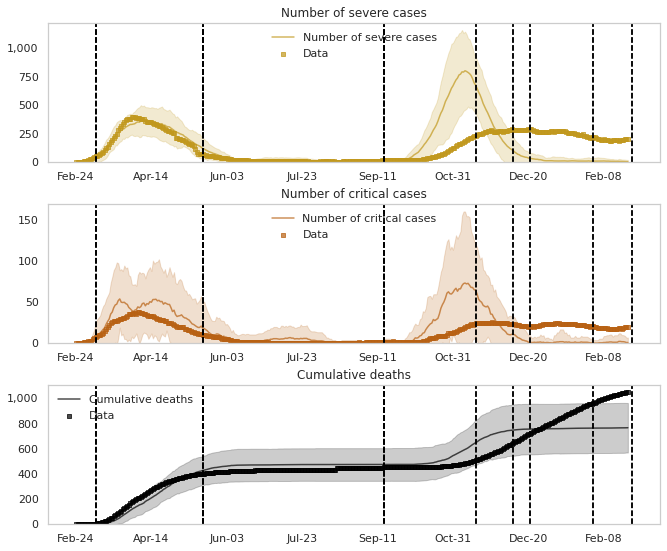

In [8]:
initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
initial_params.update(default_params)

intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
interventions = get_interventions(intervention_params)

sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

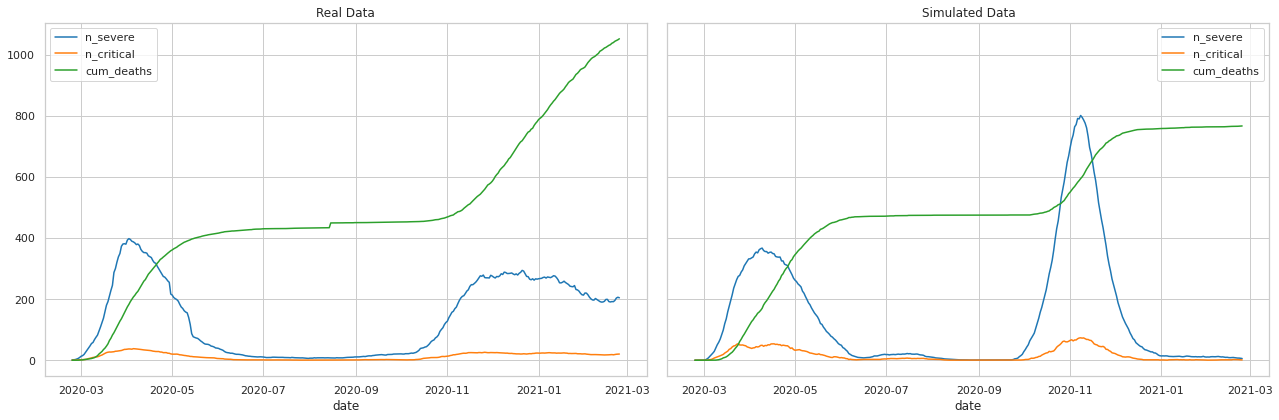

In [9]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')

plt.tight_layout()

RUN: 247


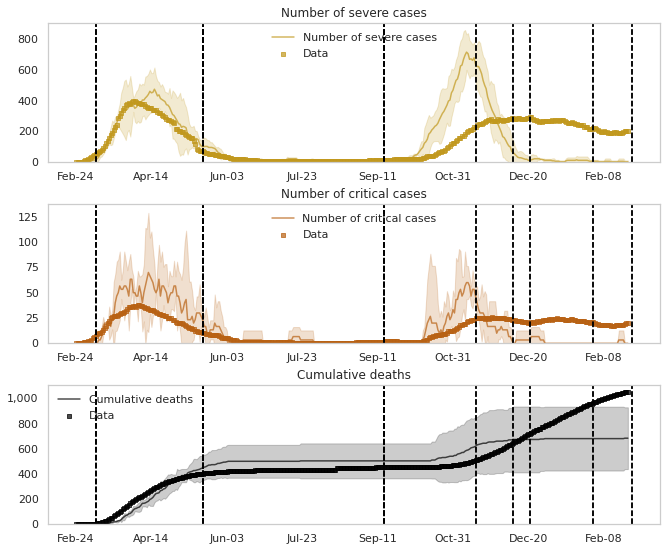



RUN: 251


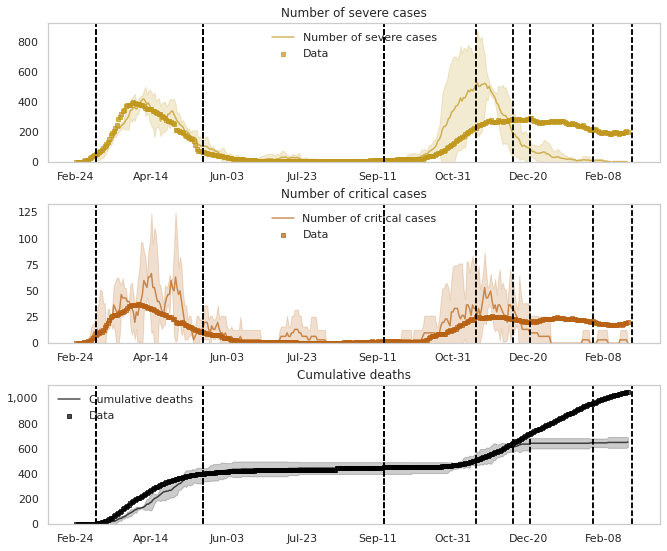



RUN: 268


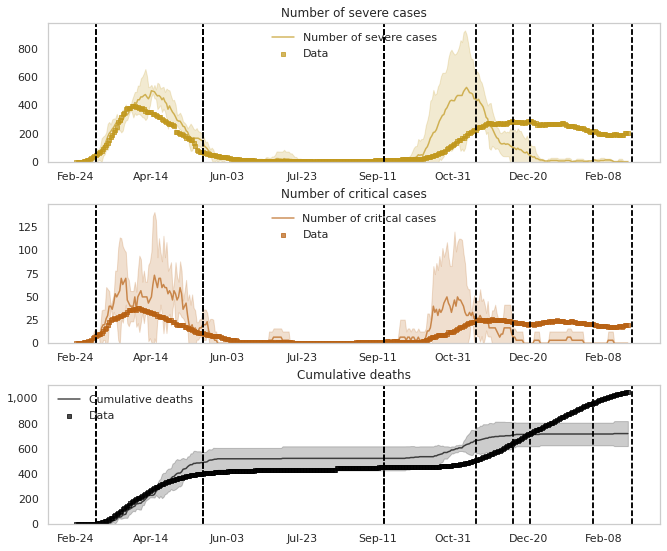



RUN: 371


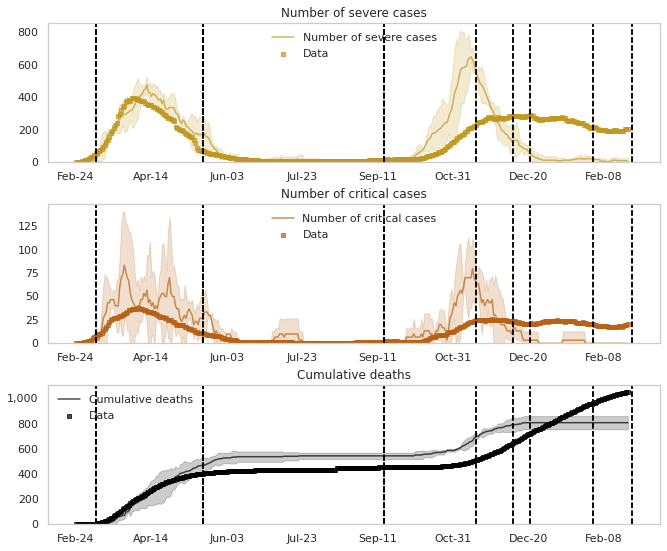



RUN: 406


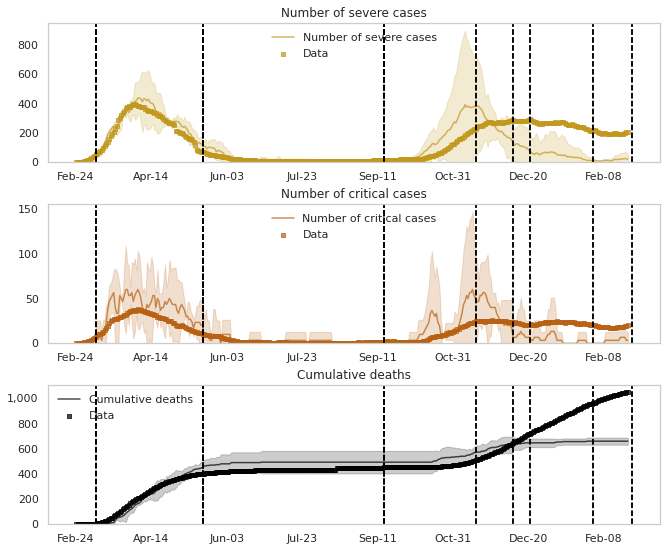



RUN: 426


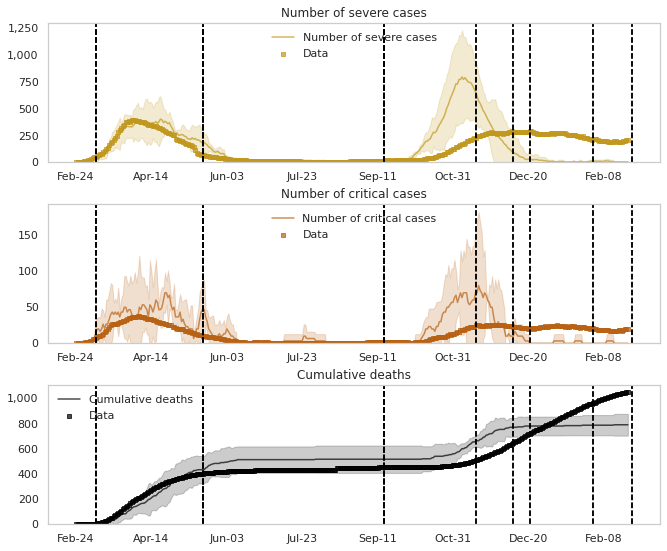



RUN: 466


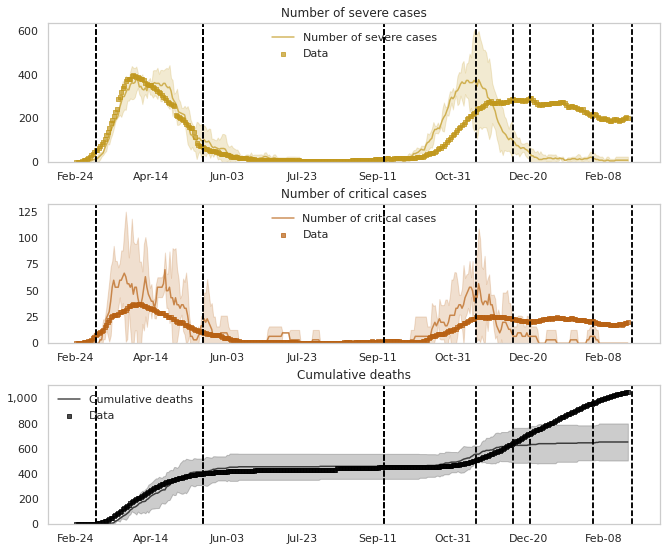



RUN: 519


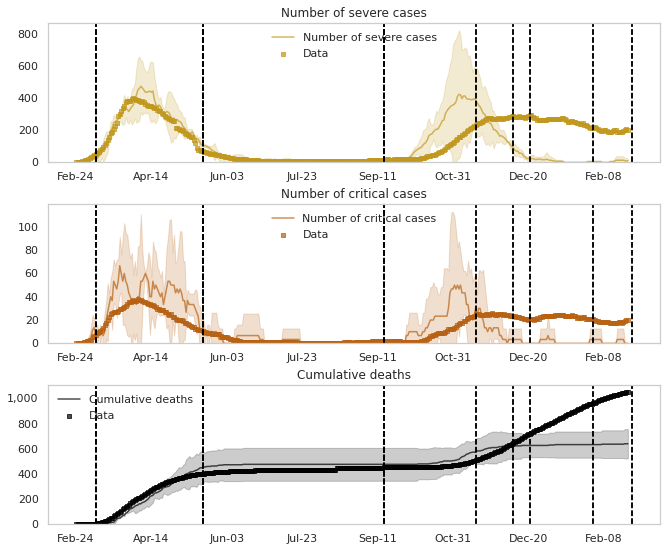



RUN: 685


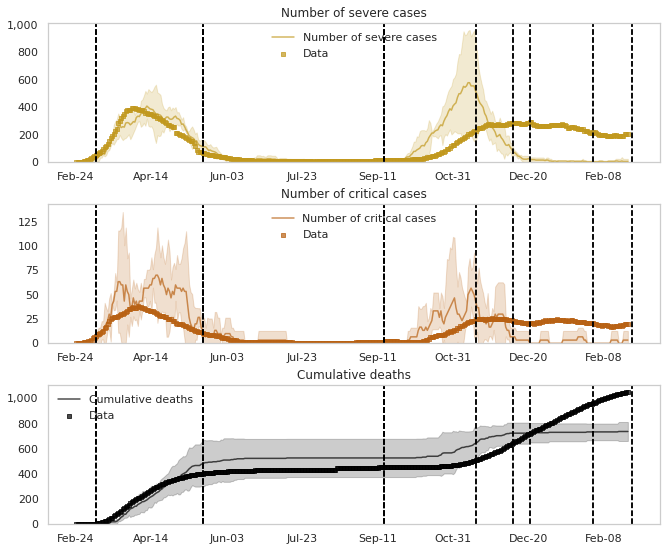



RUN: 686


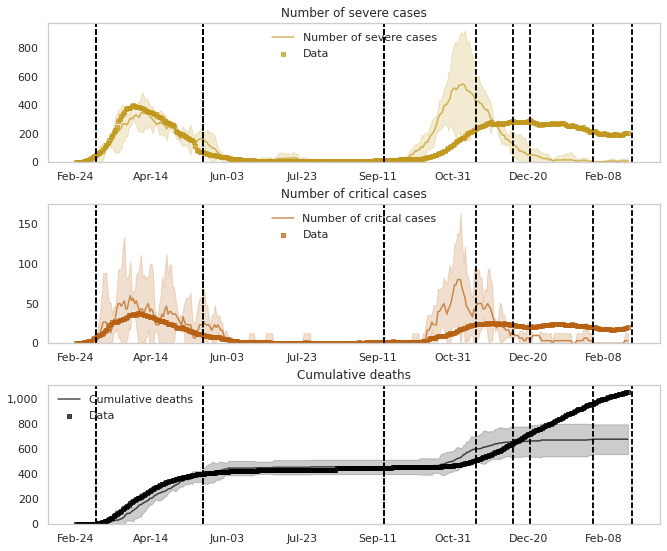



RUN: 699


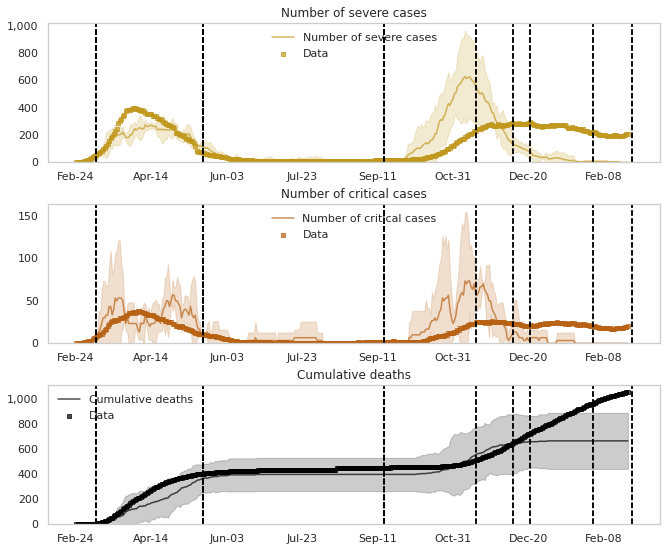



RUN: 706


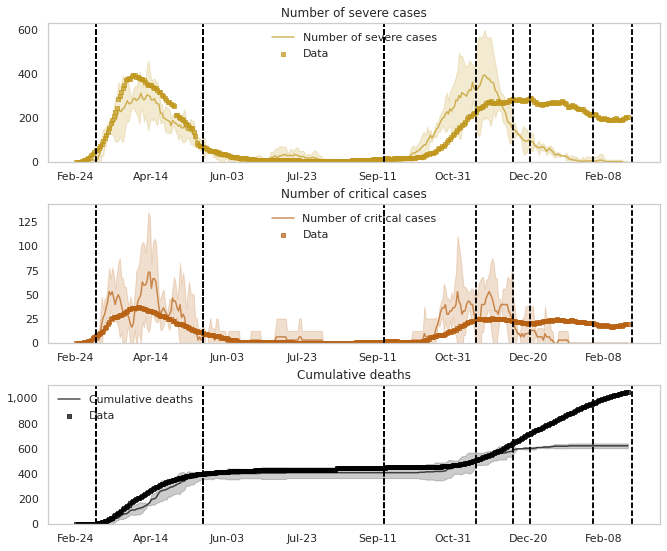



RUN: 714


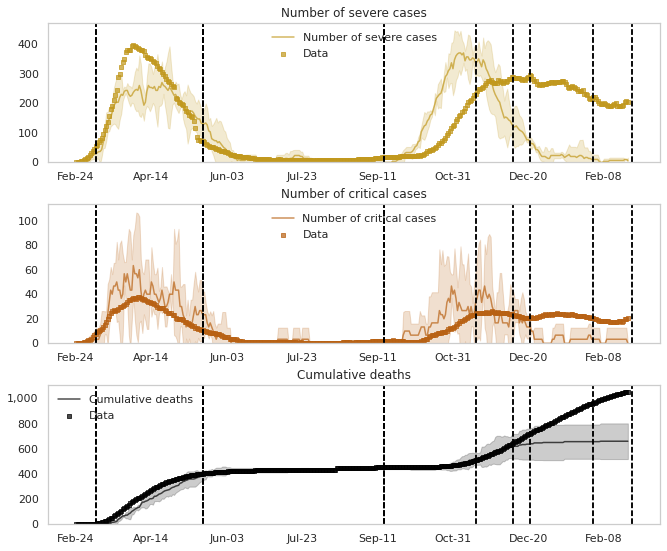



RUN: 718


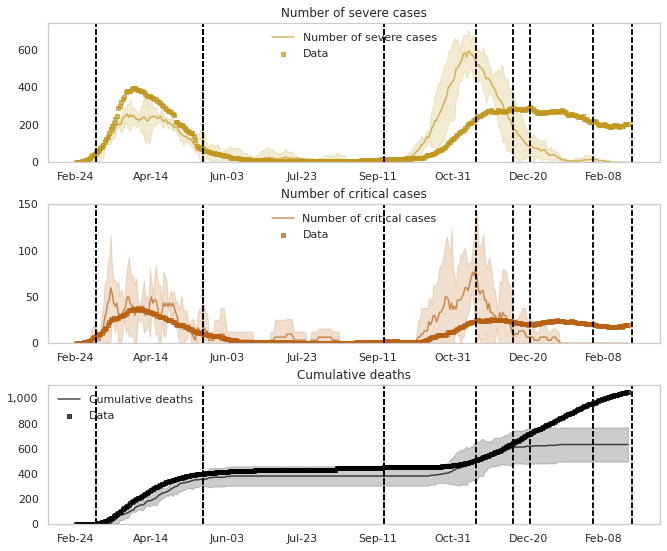



RUN: 734


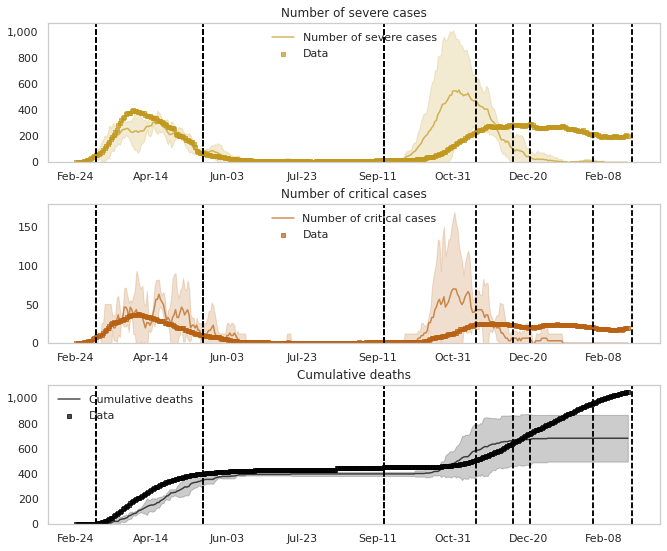



RUN: 756


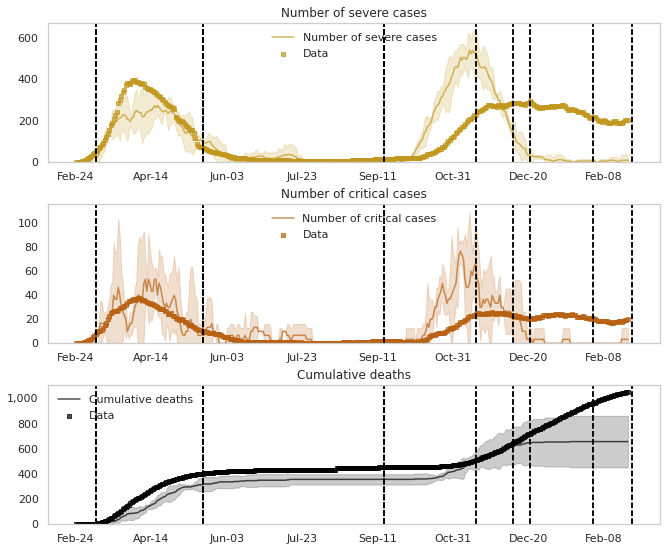



RUN: 781


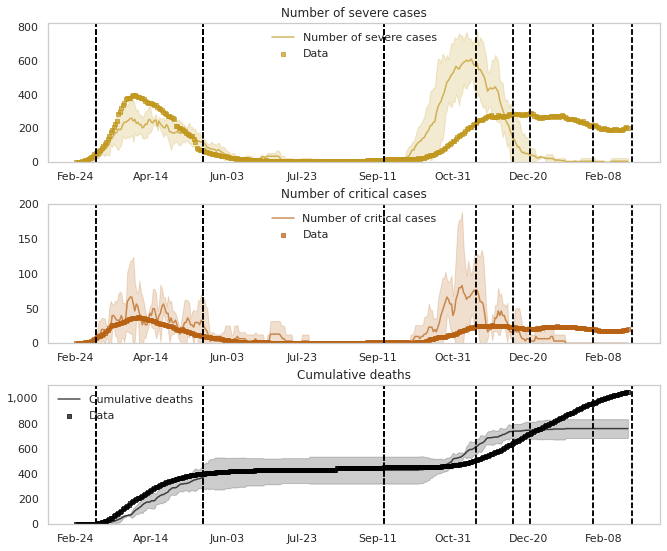



RUN: 823


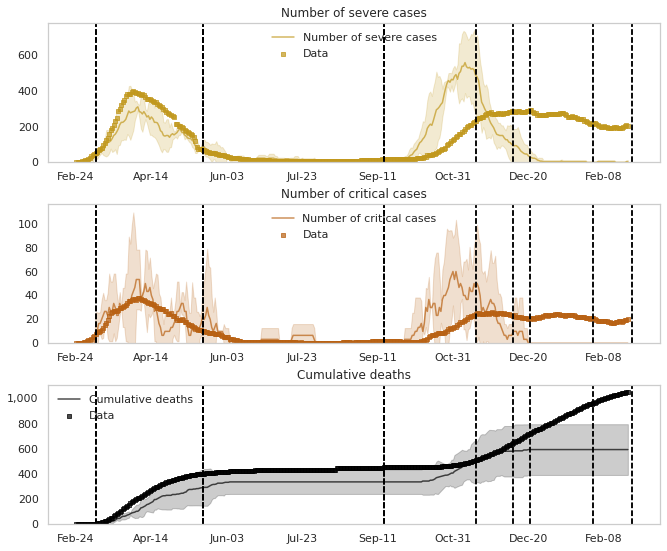



RUN: 942


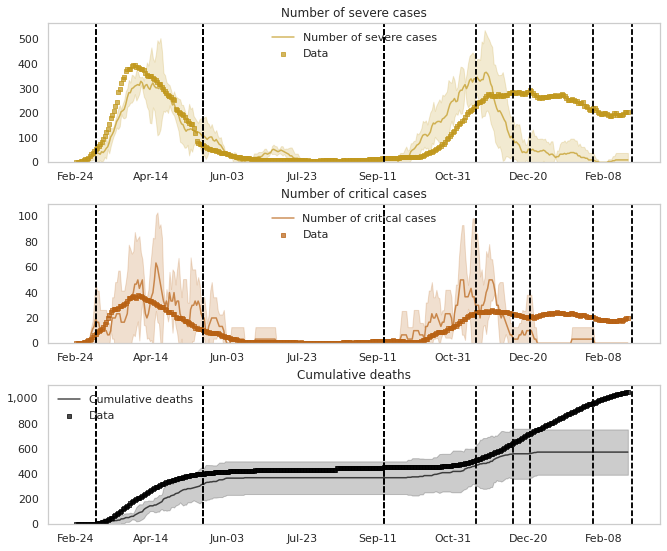



RUN: 976


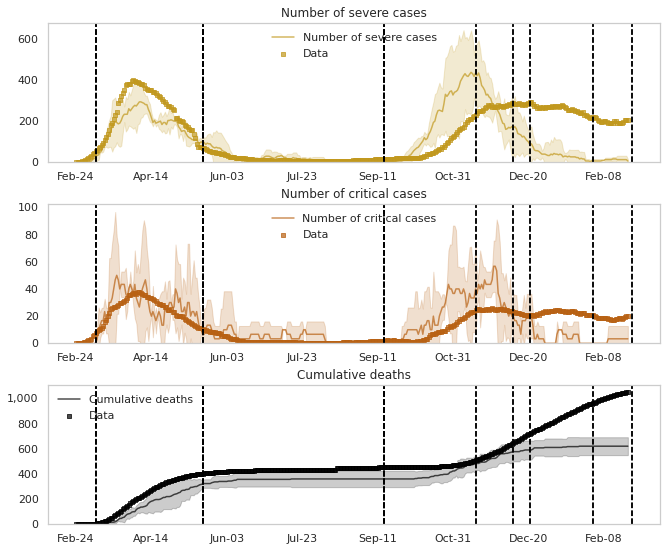

In [10]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.02)]

for id, best_params in results.iterrows():
  initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
  initial_params.update(default_params)
  intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
  interventions = get_interventions(intervention_params)
  sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
  msim = cv.MultiSim(sim)
  msim.run(n_runs=3)
  msim.mean()
  print('RUN:', id)
  msim.plot(cols)
  print('\n')

In [11]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.05)]
results.to_csv(f'res/Pop{int(pop_size/1e3)}k_Scale{pop_scale}_Winter.csv')
results

,objective,init_pop_infected,init_n_imports,init_beta,init_rel_symp_prob,init_rel_severe_prob,init_rel_crit_prob,init_rel_death_prob,interv_trace_prob,interv_trace_time,...,interv_summer_beta,interv_winter_beta,interv_summer_symp,interv_winter_symp,interv_summer_sev,interv_winter_sev,interv_summer_crit,interv_winter_crit,interv_summer_death,interv_winter_death
218,3.930974,2968,0.9,0.023,7.303894,0.133986,1.123427,5.765467,0.67,3.5,...,0.037,0.227,0.027701,4.467741,0.053685,0.494450,0.673543,0.297236,0.286663,2.321574
247,3.427180,2972,0.9,0.023,8.669258,0.128221,1.193091,7.339221,0.69,3.3,...,0.034,0.219,0.032576,3.977054,0.056356,0.416256,0.746883,0.317820,0.463788,2.371501
251,3.600295,2984,0.9,0.023,8.432123,0.124393,1.190566,7.054011,0.70,3.3,...,0.033,0.210,0.033352,3.812474,0.138860,0.428870,0.735908,0.314955,0.478452,2.400029
268,3.422342,2994,1.0,0.023,7.218221,0.121035,1.182711,7.566643,0.69,3.3,...,0.038,0.217,0.033625,3.479683,0.116310,0.437610,0.550354,0.293129,0.546235,2.423934
270,3.716727,2918,1.0,0.023,7.046424,0.116349,1.195806,7.811870,0.69,3.3,...,0.038,0.207,0.036252,3.939969,0.104655,0.450538,0.563013,0.300448,0.521368,2.423478
285,3.918208,2960,1.0,0.023,7.061444,0.119937,1.193484,7.672172,0.68,3.3,...,0.034,0.238,0.034167,3.934851,0.098114,0.412004,0.520510,0.274700,0.525971,2.359962
371,3.608867,2912,1.0,0.023,7.155401,0.136322,1.153386,7.310879,0.67,3.3,...,0.033,0.205,0.034723,6.904933,0.058562,0.451277,0.566315,0.316139,0.504662,2.466550
406,3.647935,2973,1.4,0.023,7.288692,0.121769,1.144605,7.507744,0.67,3.3,...,0.034,0.212,0.032922,7.351399,0.062272,0.444122,0.617296,0.352597,0.404590,1.993324
426,3.029031,2939,1.0,0.023,7.062441,0.120938,1.158023,7.328208,0.70,3.3,...,0.032,0.207,0.036261,7.622373,0.104680,0.499294,0.687470,0.376937,0.586248,2.457972
466,3.484408,2901,0.9,0.023,7.015576,0.119743,1.195604,7.796510,0.70,3.3,...,0.032,0.194,0.034825,3.885484,0.116046,0.410608,0.581849,0.342892,0.441677,2.441125
